In [1]:
import torch, os
import numpy as np
from tqdm import tqdm
from datetime import datetime
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

zratio = 2.5/4

In [2]:
ptag='pair4'
# btag='220902_L35D719P3_topro_brn2_ctip2_4x_11hdf_0_108na_50sw_4z_20ov_16-41-36'
btag='220904_L35D719P5_topro_brn2_ctip2_4x_0_108na_50sw_11hdf_4z_20ov_21-49-38'
device = 'cuda:3'

In [3]:

def sort_stackname(stack_names):
    stack_z = []
    for stack_name in stack_names:
        stack_z.append(int(stack_name.split('zmin')[1].split('_')[0]))

    argsort = np.argsort(stack_z)
    return [stack_names[i] for i in argsort]

def downsample(center, vol, ratio, dshape, device, skip_vol=False):
    center = center.to(device)
    vol = vol.float().to(device)
    center[:,0] = center[:,0] * ratio[0]
    center[:,1] = center[:,1] * ratio[1]
    center[:,2] = center[:,2] * ratio[2]
    z = center[:, 0].clip(min=0, max=dshape[0]-0.9)
    y = center[:, 1].clip(min=0, max=dshape[1]-0.9)
    x = center[:, 2].clip(min=0, max=dshape[2]-0.9)
    # print(center.shape, z, x, y)
    loc = torch.arange(dshape[0]*dshape[1]*dshape[2]).view(dshape[0], dshape[1], dshape[2]).to(device) 
    loc = loc[(z.long(), y.long(), x.long())] # all nis location in the downsample space
    loc_count = loc.bincount() 
    loc_count = loc_count[loc_count!=0] 
    atlas_loc = loc.unique().to(device) # unique location in the downsample space
    ## volume avg & local intensity
    vol_avg = None
    if not skip_vol:
        loc_argsort = loc.argsort().cpu()
        loc_splits = loc_count.cumsum(0).cpu()
        loc_vol = torch.tensor_split(vol[loc_argsort], loc_splits)
        assert len(loc_vol[-1]) == 0
        loc_vol = loc_vol[:-1]
        loc_vol = torch.nn.utils.rnn.pad_sequence(loc_vol, batch_first=True, padding_value=-1)
        loc_fg = loc_vol!=-1
        loc_num = loc_fg.sum(1)
        loc_vol[loc_vol==-1] = 0
        vol_avg = torch.zeros(dshape[0]*dshape[1]*dshape[2]).float()#.to(device)
        vol_avg[atlas_loc] = (loc_vol.sum(1) / loc_num).cpu().float()
        # for loci in tqdm(atlas_loc, desc="Collect NIS property in local cube"): 
        #     where_loc = torch.where(loc==loci)[0]
        #     vol_avg[loci] = vol[where_loc].mean()
        vol_avg = vol_avg.view(dshape[0], dshape[1], dshape[2])#.cpu()
    ## density map
    density = torch.zeros(dshape[0]*dshape[1]*dshape[2], dtype=torch.float64).to(device)
    density[atlas_loc] = loc_count.double() #/ center.shape[0]
    density = density.view(dshape[0], dshape[1], dshape[2]).cpu()
    return density, vol_avg

def init_nib_header():
    mask_fn = "/lichtman/Felix/Lightsheet/P4/pair15/output_L73D766P4/registered/L73D766P4_MASK_topro_25_all.nii"
    new_header = nib.load(mask_fn).header
    new_header['quatern_b'] = 0.5
    new_header['quatern_c'] = -0.5
    new_header['quatern_d'] = 0.5
    new_header['qoffset_x'] = -0.0
    new_header['qoffset_y'] = -0.0
    new_header['qoffset_z'] = 0.0
    affine_m = np.eye(4, 4)
    affine_m[:3, :3] = 0
    affine_m[0, 1] = -1
    affine_m[1, 2] = -1
    affine_m[2, 0] = 1
    return new_header, affine_m


In [4]:
overlap_r = 0.2
lrange = 1000
channel1_tag = 'C00'
channel2_tag = 'C02'
root1 = '/cajal/Felix/Lightsheet/P4'
root2 = '/lichtman/Felix/Lightsheet/P4'
root = f'{root1}/{ptag}/{btag}' if os.path.exists(f'{root1}/{ptag}/{btag}') else f'{root2}/{ptag}/{btag}'
assert os.path.exists(root), root
img_tag = 'UltraII[%02d x %02d]'
save_path = f'/cajal/ACMUSERS/ziquanw/Lightsheet/colocalization/{ptag}/{btag.split("_")[1]}/{img_tag}'
result_path = f'/cajal/ACMUSERS/ziquanw/Lightsheet/results/P4/{ptag}/{btag}'
result_root = result_path + '/UltraII[%02d x %02d]'
stack_names = [f for f in os.listdir(result_root % (0, 0)) if f.endswith('instance_center.zip')]
stack_names = sort_stackname(stack_names)
meta_name = stack_names[0].replace('instance_center', 'seg_meta')
seg_shape = torch.load(f'{result_root % (0, 0)}/{meta_name}')
tile_loc = np.array([[int(fn[8:10]), int(fn[-3:-1])] for fn in os.listdir(result_path)])
ncol, nrow = tile_loc.max(0)+1
seg_shape = [s.item() for s in seg_shape]
print(stack_names, ncol, nrow)

['L35D719P5_NIScpp_results_zmin0_instance_center.zip', 'L35D719P5_NIScpp_results_zmin958_instance_center.zip'] 3 5


In [5]:
i,j = 0,0
os.makedirs(save_path % (i, j), exist_ok=True)
img_fns = [fn for fn in os.listdir(root) if img_tag % (i, j) in fn]
seg_shape[0] = len(img_fns) // 3
img3d_c1 = np.zeros(seg_shape)
for fn in tqdm(img_fns, desc=f'{datetime.now()} Load tiles {i},{j} {channel1_tag}'):
    if channel1_tag not in fn: continue
    zi = int(fn.split(' Z')[1][:4])
    img = Image.open(f'{root}/{fn}')
    img = np.asarray(img)
    img3d_c1[zi] = img

img3d_c2 = np.zeros(seg_shape)
for fn in tqdm(img_fns, desc=f'{datetime.now()} Load tiles {i},{j} {channel2_tag}'):
    if channel2_tag not in fn: continue
    zi = int(fn.split(' Z')[1][:4])
    img = Image.open(f'{root}/{fn}')
    img = np.asarray(img)
    img3d_c2[zi] = img


2024-07-29 11:17:33.581970 Load tiles 0,0 C02: 100%|██████████████████████| 3153/3153 [02:29<00:00, 21.12it/s]


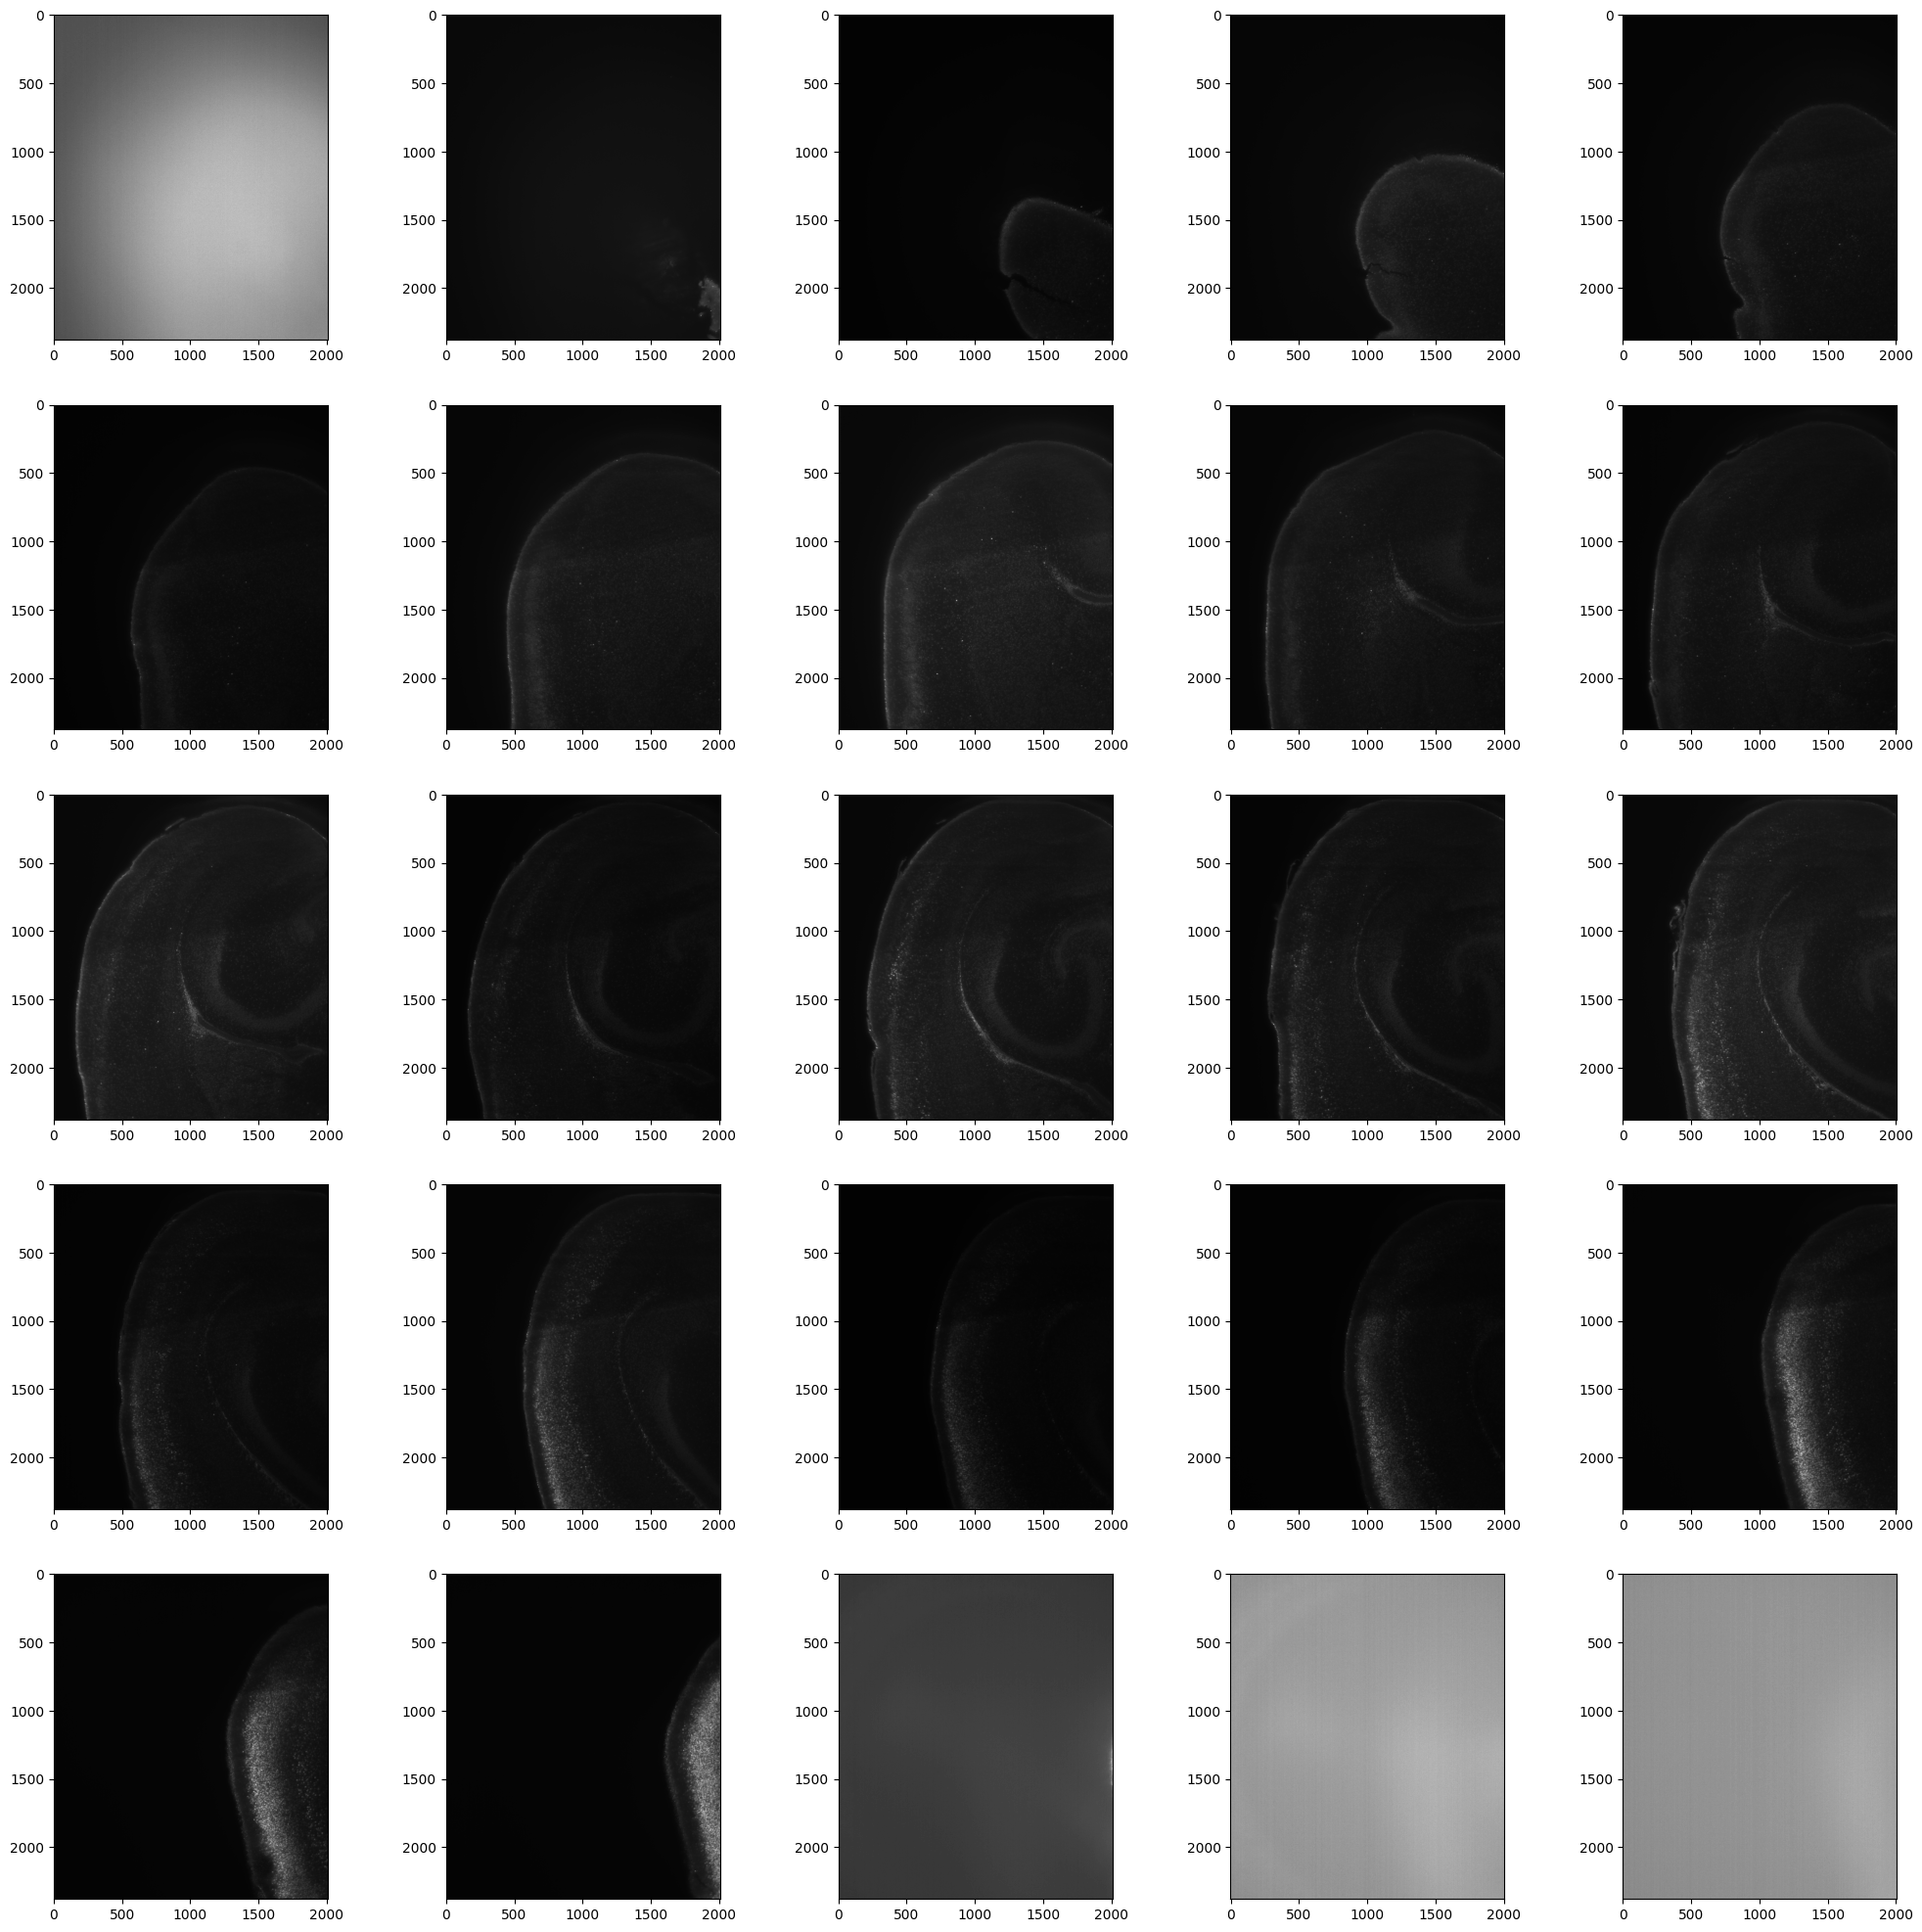

In [14]:
vis_row_n = 5
fig, ax = plt.subplots(vis_row_n, vis_row_n, figsize=(5*vis_row_n, 5*vis_row_n))
ax = ax.reshape(-1)
zinterval = int(len(img3d_c1)/(vis_row_n**2-1))
zranges = [[z, z+zinterval] for z in range(0, len(img3d_c1), zinterval)]
zranges = zranges[:len(ax)]
for zi, (zmin, zmax) in enumerate(zranges):
    z = (zmax+zmin)//2
    z = min(len(img3d_c1)-1, z)
    ax[zi].imshow(img3d_c1[z], cmap='gray')


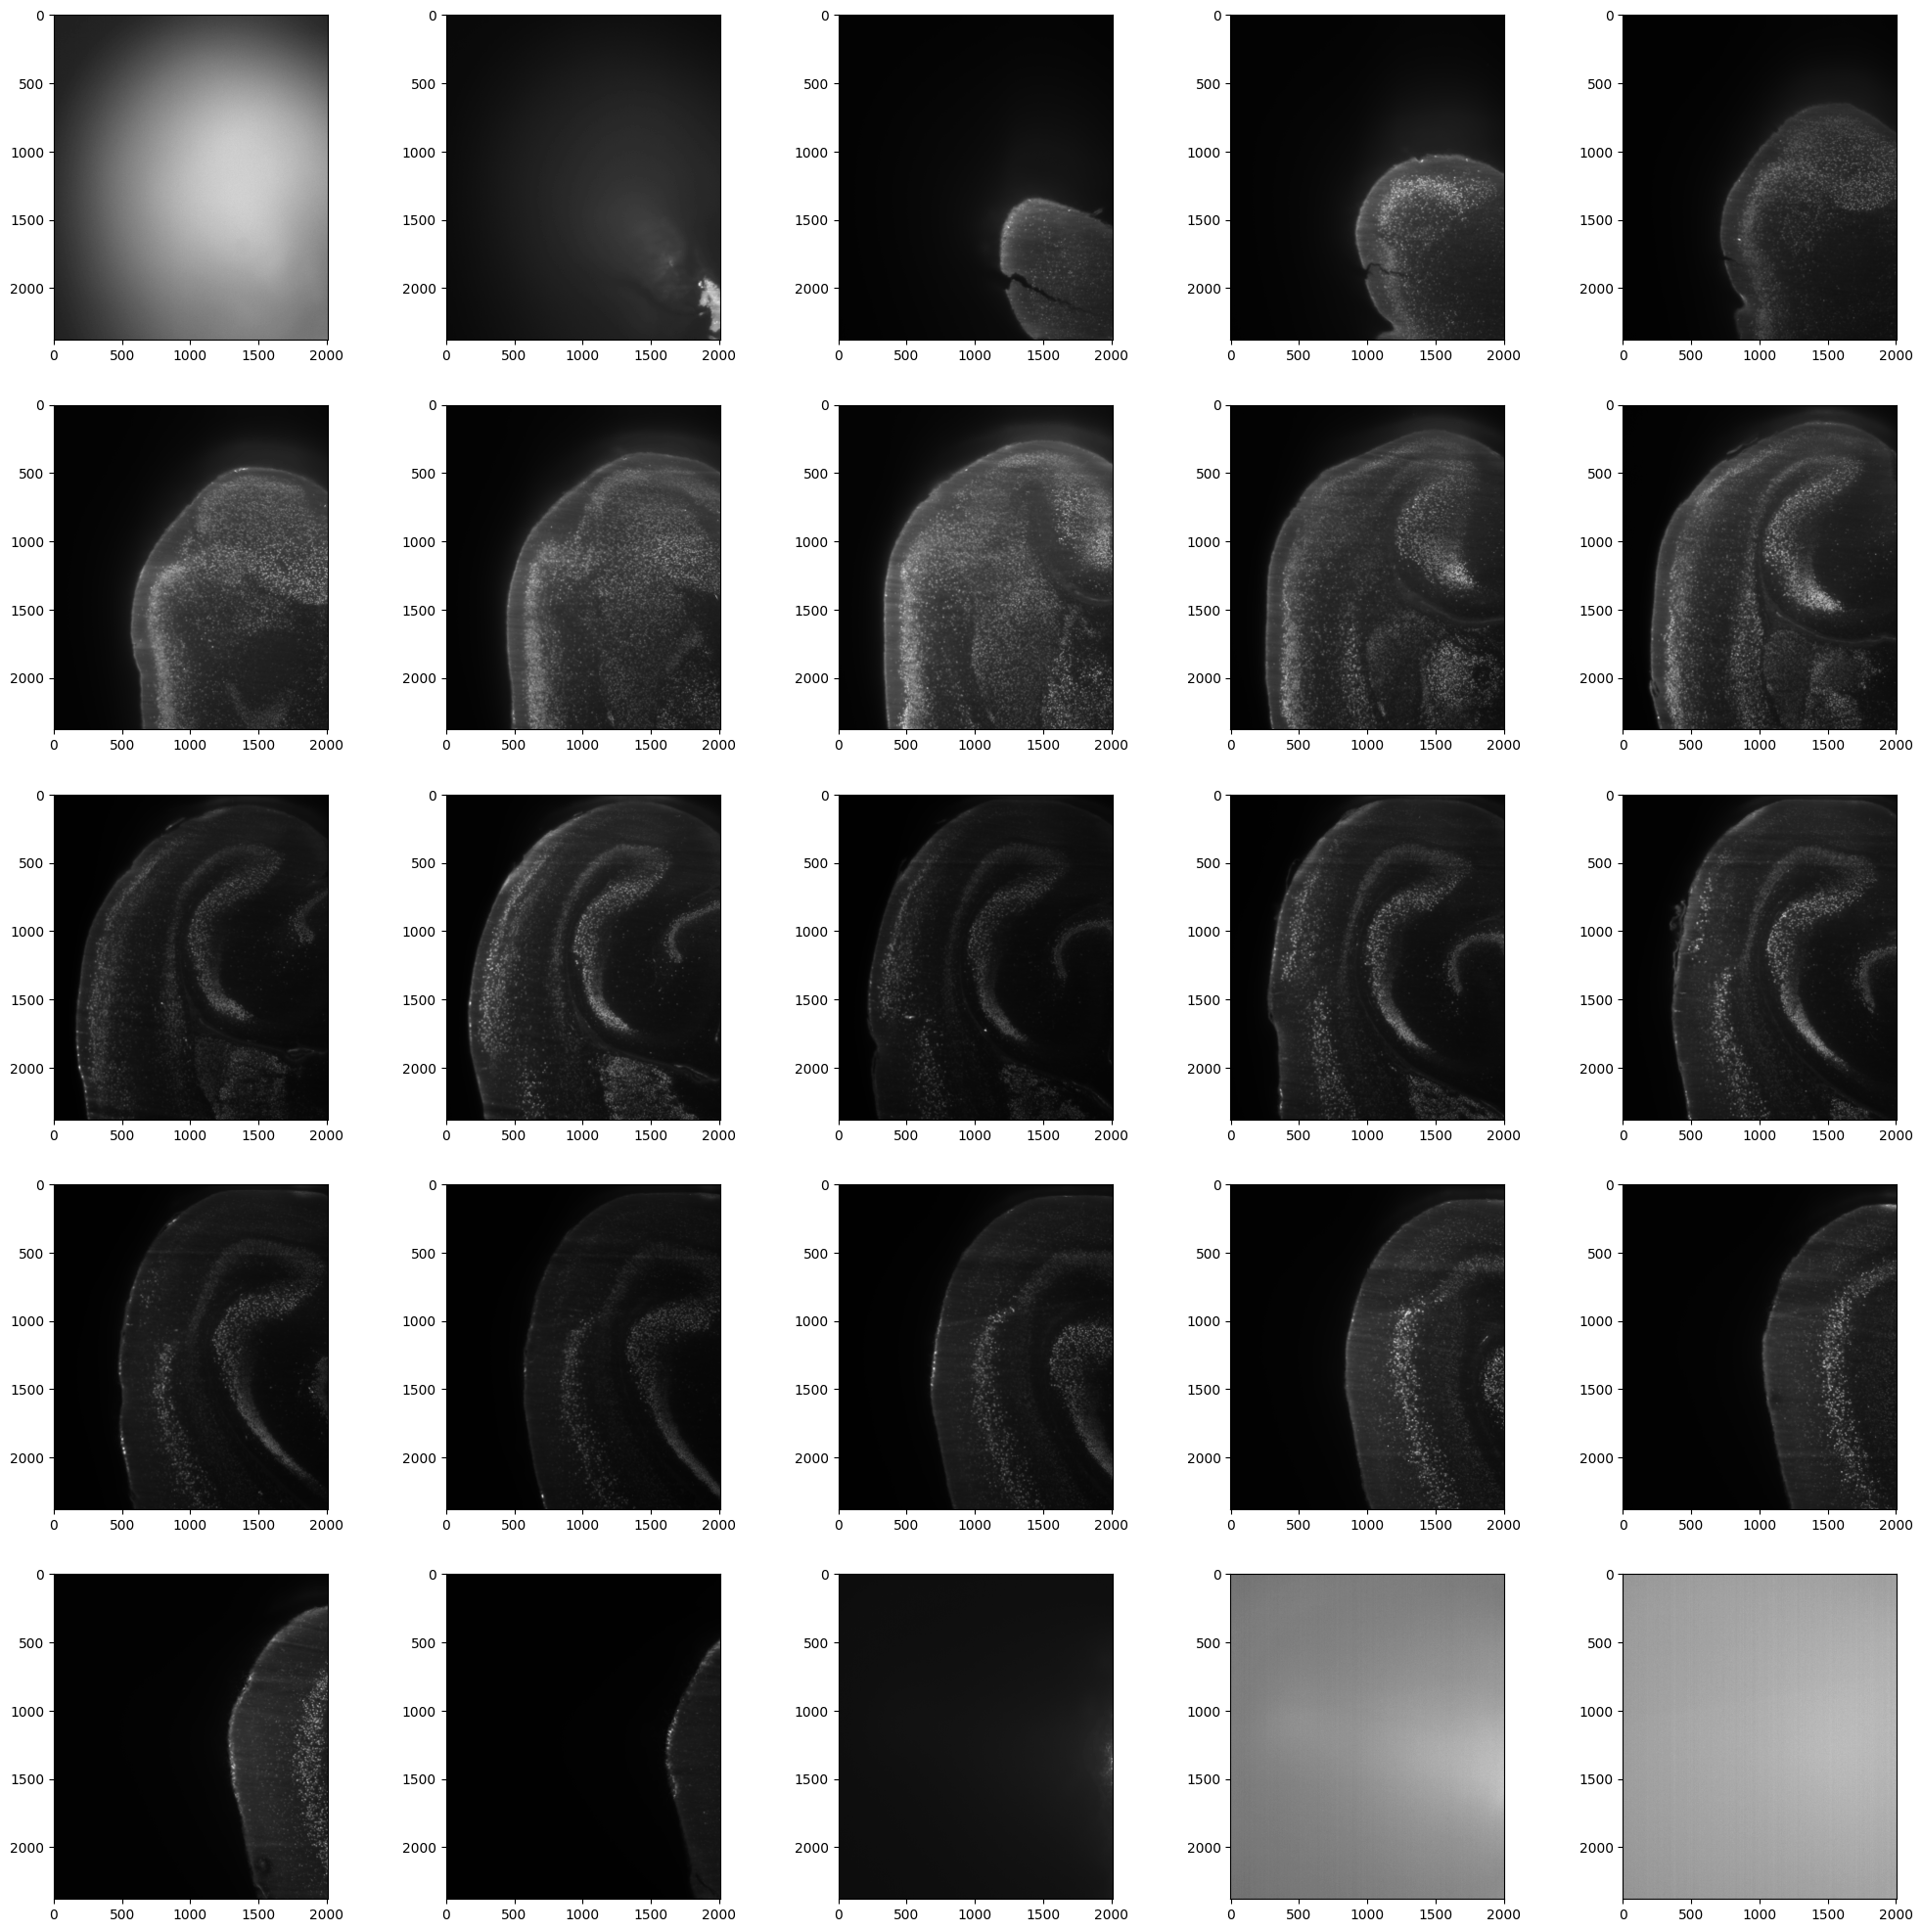

In [15]:

fig, ax = plt.subplots(vis_row_n, vis_row_n, figsize=(5*vis_row_n, 5*vis_row_n))
ax = ax.reshape(-1)
zinterval = int(len(img3d_c2)/(vis_row_n**2-1))
zranges = [[z, z+zinterval] for z in range(0, len(img3d_c2), zinterval)]
zranges = zranges[:len(ax)]
for zi, (zmin, zmax) in enumerate(zranges):
    z = (zmax+zmin)//2
    z = min(len(img3d_c2)-1, z)
    ax[zi].imshow(img3d_c2[z], cmap='gray')


In [6]:
tile_lt_loc = {
    f'{i}-{j}': [i*seg_shape[1]*(1-overlap_r), j*seg_shape[2]*(1-overlap_r)] for i in range(ncol) for j in range(nrow)
}
whole_brain_shape = [seg_shape[0]] + list(np.array(list(tile_lt_loc.values())).max(0) + np.array(seg_shape[1:]))
whole_brain_shape = [int(s) for s in whole_brain_shape]
whole_brain_shape

[1051, 6185, 8429]

In [7]:
img3d_c1 = torch.from_numpy(img3d_c1).float()
img3d_c2 = torch.from_numpy(img3d_c2).float()

In [18]:
# down_ratio = 0.1
# down_img3d_c1 = torch.nn.functional.interpolate(img3d_c1[None, None], scale_factor=[down_ratio, down_ratio, down_ratio])[0, 0]
# down_img3d_c2 = torch.nn.functional.interpolate(img3d_c2[None, None], scale_factor=[down_ratio, down_ratio, down_ratio])[0, 0]
# # down_binary_mask = torch.nn.functional.interpolate(binary_mask[None, None].float(), scale_factor=[down_ratio, down_ratio, down_ratio])[0, 0] > 0
# # print(down_binary_mask.shape)
# print(down_img3d_c1.shape, down_img3d_c2.shape)

torch.Size([105, 237, 200]) torch.Size([105, 237, 200])


In [8]:
down_ratio = 0.1
D = len(whole_brain_shape)
brain_center = torch.LongTensor([(s/2) for s in whole_brain_shape])
tile_grid = torch.meshgrid(torch.arange(int(img3d_c1.shape[0]*down_ratio)), torch.arange(int(img3d_c1.shape[1]*down_ratio)), torch.arange(int(img3d_c1.shape[2]*down_ratio)))
tile_grid = torch.stack(tile_grid)
tile_grid[1] = tile_grid[1] + down_ratio*tile_lt_loc[f'{i}-{j}'][0]
tile_grid[2] = tile_grid[2] + down_ratio*tile_lt_loc[f'{i}-{j}'][1]
tile_grid = tile_grid / down_ratio
grid_dis_to_center = tile_grid - brain_center[:, None, None, None]
grid_dis_to_center = (grid_dis_to_center**2).sum(0).sqrt()
print(grid_dis_to_center.shape, grid_dis_to_center.max(), grid_dis_to_center.min())

/ram/USERS/ziquanw/softwares/miniconda3/envs/wholeBrain/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([105, 237, 200]) tensor(5252.9883) tensor(2341.3726)


In [9]:
org_grid_dis_to_center = torch.nn.functional.interpolate(grid_dis_to_center[None,None], size=img3d_c1.shape)[0,0]
print(org_grid_dis_to_center.shape)

torch.Size([1051, 2379, 2007])


In [39]:
'''
Run Otsu for every distance to center
'''
from skimage.filters import threshold_otsu
nbins = 256
distance_group_n = 5
dinterval = int((grid_dis_to_center.max() - grid_dis_to_center.min())/distance_group_n)
dranges = [[d, d+dinterval] for d in range(grid_dis_to_center.min().long(), grid_dis_to_center.max().long()+1, dinterval)]
# print(dranges)
fg_mask_c1 = torch.zeros_like(img3d_c1).bool()
fg_mask_c2 = torch.zeros_like(img3d_c2).bool()
for di, (dmin, dmax) in enumerate(dranges):
    print(dmin, dmax)
    dmask = torch.logical_and(org_grid_dis_to_center >= dmin, org_grid_dis_to_center < dmax)
    c1 = img3d_c1[dmask].numpy()
    th_c1 = threshold_otsu(image=c1, nbins=nbins)
    c2 = img3d_c2[dmask].numpy()
    th_c2 = threshold_otsu(image=c2, nbins=nbins)
    print(c1.shape, th_c1, th_c2)
    fg_mask_c1[torch.logical_and(img3d_c1>th_c1, dmask)] = True
    fg_mask_c2[torch.logical_and(img3d_c2>th_c2, dmask)] = True
    

2341 2923
(429484212,) 1314.498 1943.7832
2923 3505
(1135592582,) 1151.9824 2248.4766
3505 4087
(1678067438,) 457.625 1663.9746
4087 4669
(1382099682,) 127.99805 1776.75
4669 5251
(392910218,) 67.56836 186.43945
5251 5833
(6171,) 0.296875 120.09375


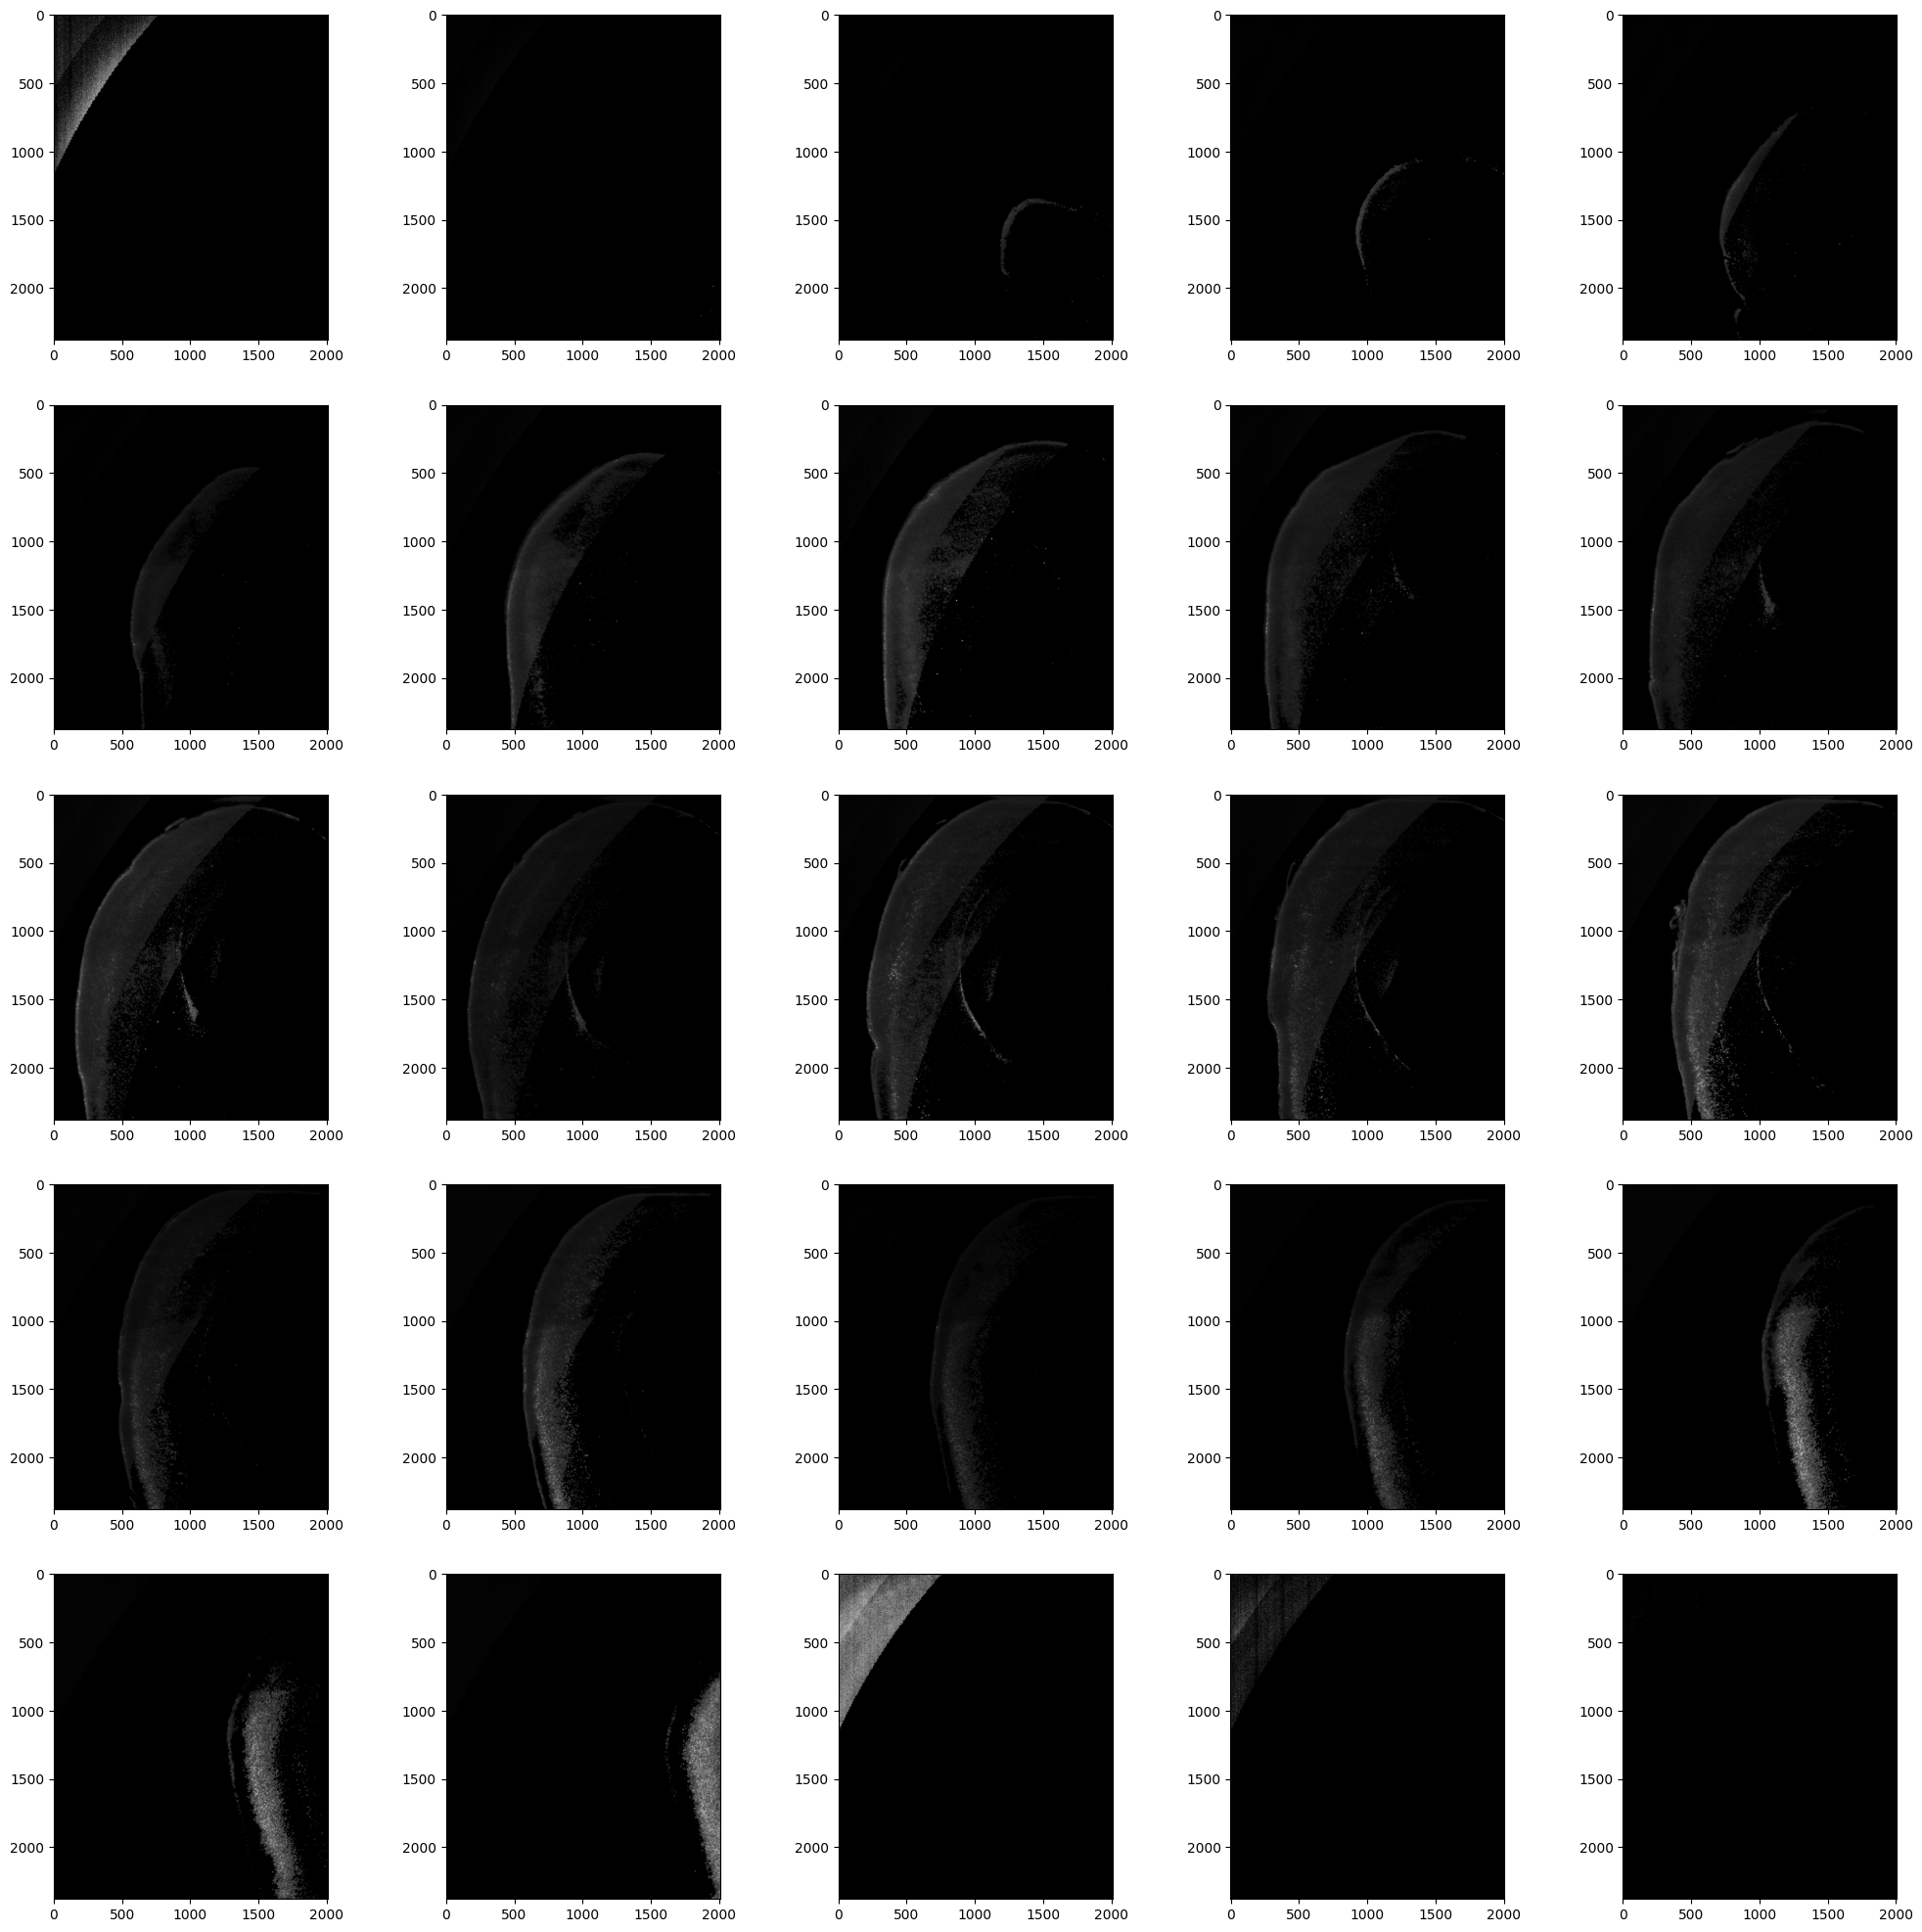

In [40]:
'''
Coloring fg mask
'''

fig, ax = plt.subplots(vis_row_n, vis_row_n, figsize=(5*vis_row_n, 5*vis_row_n))
ax = ax.reshape(-1)
zinterval = int(len(img3d_c1)/(vis_row_n**2-1))
zranges = [[z, z+zinterval] for z in range(0, len(img3d_c1), zinterval)]
zranges = zranges[:len(ax)]
pix_max = img3d_c1.max()
pix_min = img3d_c1.min()
for zi, (zmin, zmax) in enumerate(zranges):
    z = (zmax+zmin)//2
    z = min(len(img3d_c1)-1, z)
    img_fg = img3d_c1[z].clone()
#     img_all = img3d_c1[z].clone()
#     img_all = (img_all-img3d_c1[z].min()) / (img3d_c1[z].max()-img3d_c1[z].min())
#     img_fg = (img_fg-img3d_c1[z].min()) / (img3d_c1[z].max()-img3d_c1[z].min())
    img_fg[torch.logical_not(fg_mask_c1[z])] = 0
    ax[zi].imshow(img_fg, cmap='gray')


In [10]:
binary_mask = []
bshape = 0
for stack_name in stack_names:
    fn = f"{result_root % (i, j)}/{stack_name.replace('instance_center', 'binary_mask')}"
    b = torch.load(fn).to(device)
    new_b = []
    for xi in range(b.shape[1]):
        new_b.append(torch.nn.functional.interpolate(b[None, None, :, xi].float(), scale_factor=[zratio, 1])[0, 0] > 0)
    new_b = torch.stack(new_b, dim=1).cpu()
    bshape += new_b.shape[0]
    binary_mask.append(new_b)

binary_mask = torch.cat(binary_mask+[torch.zeros(seg_shape[0]-bshape, seg_shape[1], seg_shape[2]).bool()])
print(binary_mask.shape, binary_mask.dtype)

torch.Size([1051, 2379, 2007]) torch.bool


In [11]:
from tqdm import tqdm, trange

inflate_size = 7

inflater = torch.nn.MaxPool2d(3, stride=1, padding=1).to(device)
around_nis = torch.zeros_like(binary_mask).bool()
for z in trange(len(binary_mask)):
    bg = binary_mask[z].float().to(device)
    for _ in range(inflate_size):
        bg = inflater(bg[None, None])[0, 0]
    bg = bg > 0
    around_nis[z] = bg.cpu()
    
print(around_nis.shape, around_nis.dtype)

100%|████████████████████████████████████████████████████████████████████| 1051/1051 [00:03<00:00, 346.58it/s]

torch.Size([1051, 2379, 2007]) torch.bool


In [12]:
'''
Run Otsu for every distance to center around NIS
'''
from skimage.filters import threshold_otsu
nbins = 256
distance_group_n = 500
dinterval = int((grid_dis_to_center.max() - grid_dis_to_center.min())/distance_group_n)
dranges = [[d, d+dinterval] for d in range(grid_dis_to_center.min().long(), grid_dis_to_center.max().long()+1, dinterval)]
print(dranges[:10])
fg_mask_c1 = torch.zeros_like(img3d_c1).bool()
fg_mask_c2 = torch.zeros_like(img3d_c2).bool()
th_c1s = []
th_c2s = []
for di, (dmin, dmax) in tqdm(enumerate(dranges), total=len(dranges)):
#     print(dmin, dmax)
    dmask = torch.logical_and(org_grid_dis_to_center >= dmin, org_grid_dis_to_center < dmax)
    mask = torch.logical_and(dmask, around_nis)
    if not mask.any(): continue
    c1 = img3d_c1[mask].numpy()
    th_c1 = threshold_otsu(image=c1, nbins=nbins)
    c2 = img3d_c2[mask].numpy()
    th_c2 = threshold_otsu(image=c2, nbins=nbins)
#     print(c1.shape, th_c1, th_c2)
    fg_mask_c1[torch.logical_and(img3d_c1>th_c1, dmask)] = True
    fg_mask_c2[torch.logical_and(img3d_c2>th_c2, dmask)] = True
    th_c1s.append(th_c1)
    th_c2s.append(th_c2)
    
    

0it [00:00, ?it/s]

(34154,) 327.21094 1479.9238


1it [00:06,  6.38s/it]

(45799,) 318.94922 1506.5273


2it [00:12,  6.22s/it]

(101073,) 367.29883 1567.0234


3it [00:18,  6.27s/it]

(132242,) 343.8125 1457.1504


4it [00:24,  5.88s/it]

(186018,) 389.9121 1404.5586


5it [00:29,  5.73s/it]

(234556,) 530.6328 1627.2207


6it [00:34,  5.48s/it]

(293685,) 1461.9316 1554.3965


7it [00:39,  5.46s/it]

(369728,) 1413.8652 1801.1719


8it [00:46,  5.70s/it]

(413827,) 1430.8633 1747.9883


9it [00:51,  5.51s/it]

(479480,) 1364.2617 1913.9648


10it [00:58,  6.15s/it]

(533306,) 1374.2559 1884.1387


11it [01:03,  5.82s/it]

(604454,) 1305.3945 2077.082


12it [01:10,  5.93s/it]

(684166,) 1338.4434 1980.7891


13it [01:16,  6.07s/it]

(704943,) 1303.4102 2892.957


14it [01:22,  6.15s/it]

(796807,) 1306.752 2518.6035


15it [01:28,  5.92s/it]

(841154,) 1345.248 2793.3262


16it [01:32,  5.35s/it]

(893334,) 1398.7051 2562.4688


17it [01:36,  5.01s/it]

(974455,) 1382.168 2613.457


18it [01:40,  4.76s/it]

(999485,) 1359.9707 2728.2715


19it [01:45,  4.67s/it]

(1072571,) 1409.6992 2814.8496


20it [01:49,  4.65s/it]

(1115745,) 1338.9004 2837.5332


21it [01:54,  4.64s/it]

(1198824,) 1366.7969 2523.0352


22it [01:59,  4.65s/it]

(1226977,) 1392.9805 2540.5312


23it [02:03,  4.61s/it]

(1292328,) 1346.8477 2703.7441


24it [02:08,  4.68s/it]

(1360227,) 1380.6133 2525.8066


25it [02:14,  5.09s/it]

(1383421,) 1355.377 2594.9336


26it [02:20,  5.47s/it]

(1464627,) 1422.5938 2503.5098


27it [02:25,  5.22s/it]

(1513327,) 1384.793 2511.787


28it [02:31,  5.35s/it]

(1586215,) 1324.6094 2633.2656


29it [02:36,  5.35s/it]

(1612414,) 1370.3555 2643.1758


30it [02:41,  5.35s/it]

(1658346,) 1358.998 2378.0762


31it [02:46,  5.09s/it]

(1751943,) 1373.7988 2556.6816


32it [02:51,  5.05s/it]

(1757200,) 1334.4648 2604.8203


33it [02:58,  5.58s/it]

(1844355,) 1388.4902 2594.539


34it [03:05,  6.11s/it]

(1866375,) 1361.7246 2597.5625


35it [03:11,  6.15s/it]

(1918783,) 1325.6875 2596.584


36it [03:16,  5.84s/it]

(1977546,) 1404.1816 2621.336


37it [03:21,  5.60s/it]

(1987868,) 1369.4473 2818.0625


38it [03:27,  5.55s/it]

(2105516,) 1453.6035 2553.3027


39it [03:32,  5.49s/it]

(2102552,) 1373.3789 2623.504


40it [03:38,  5.49s/it]

(2208549,) 1374.457 2591.6406


41it [03:43,  5.51s/it]

(2225021,) 1395.9805 2596.832


42it [03:48,  5.45s/it]

(2273660,) 1395.0234 2624.7832


43it [03:54,  5.51s/it]

(2336906,) 1373.6699 2498.6035


44it [04:00,  5.66s/it]

(2360274,) 1397.207 2582.9648


45it [04:06,  5.69s/it]

(2425950,) 1440.4238 2523.3574


46it [04:12,  5.71s/it]

(2468680,) 1446.334 2642.709


47it [04:17,  5.60s/it]

(2550083,) 1416.2207 2589.0586


48it [04:23,  5.60s/it]

(2606857,) 1409.6074 2607.1992


49it [04:28,  5.65s/it]

(2600219,) 1431.168 2609.0781


50it [04:34,  5.65s/it]

(2689492,) 1418.1797 2619.123


51it [04:40,  5.65s/it]

(2711447,) 1378.0996 2606.832


52it [04:45,  5.60s/it]

(2754016,) 1425.2246 2606.662


53it [04:51,  5.63s/it]

(2781816,) 1385.9238 2597.4805


54it [04:57,  5.76s/it]

(2840750,) 1351.0215 2526.7246


55it [05:03,  5.75s/it]

(2907147,) 1382.5625 2551.6133


56it [05:08,  5.68s/it]

(2928350,) 1332.6973 2606.209


57it [05:13,  5.48s/it]

(3024361,) 1379.0996 2620.6836


58it [05:18,  5.37s/it]

(3032146,) 1395.8926 2622.414


59it [05:23,  5.31s/it]

(3087619,) 1369.7246 2525.3652


60it [05:29,  5.34s/it]

(3118491,) 1357.7188 2603.5137


61it [05:34,  5.39s/it]

(3145190,) 1369.168 2557.9062


62it [05:40,  5.42s/it]

(3199249,) 1366.9512 2593.8164


63it [05:45,  5.43s/it]

(3247991,) 1300.9688 2582.8945


64it [05:51,  5.46s/it]

(3291065,) 1314.3457 2544.8164


65it [05:56,  5.46s/it]

(3340569,) 1314.8086 2581.2695


66it [06:02,  5.48s/it]

(3376175,) 1325.0586 2551.371


67it [06:07,  5.51s/it]

(3421925,) 1315.7949 2480.836


68it [06:13,  5.45s/it]

(3419008,) 1319.0684 2696.9648


69it [06:18,  5.44s/it]

(3519384,) 1310.5312 2615.9043


70it [06:23,  5.33s/it]

(3510160,) 1331.4355 2657.6016


71it [06:28,  5.29s/it]

(3594956,) 1336.0078 2702.3926


72it [06:34,  5.31s/it]

(3616237,) 1332.3496 2615.209


73it [06:39,  5.37s/it]

(3689134,) 1353.0215 2577.713


74it [06:45,  5.43s/it]

(3735563,) 1338.1074 2620.8105


75it [06:50,  5.46s/it]

(3761609,) 1340.9121 2575.1836


76it [06:56,  5.41s/it]

(3806584,) 1317.3281 2645.3848


77it [07:01,  5.40s/it]

(3851490,) 1358.5215 2689.836


78it [07:06,  5.44s/it]

(3860478,) 1299.9688 2723.8535


79it [07:12,  5.48s/it]

(3949835,) 1368.0801 2669.834


80it [07:18,  5.48s/it]

(3930912,) 1346.2559 2648.4668


81it [07:23,  5.48s/it]

(4036806,) 1341.252 2621.8477


82it [07:28,  5.47s/it]

(4050676,) 1397.8379 2587.7734


83it [07:34,  5.37s/it]

(4076207,) 1410.4453 2563.3535


84it [07:39,  5.26s/it]

(4129660,) 1347.1758 2645.0742


85it [07:44,  5.21s/it]

(4161171,) 1364.9805 2639.7246


86it [07:49,  5.16s/it]

(4202412,) 1374.8555 2632.748


87it [07:54,  5.19s/it]

(4192672,) 1382.3516 2608.0781


88it [07:59,  5.20s/it]

(4267031,) 1388.6484 2603.4824


89it [08:05,  5.25s/it]

(4314638,) 1380.168 2631.2383


90it [08:10,  5.25s/it]

(4363674,) 1392.7949 2603.957


91it [08:15,  5.23s/it]

(4433976,) 1401.1914 2638.7383


92it [08:20,  5.24s/it]

(4409051,) 1400.5273 2596.4707


93it [08:26,  5.24s/it]

(4471516,) 1362.5605 2772.254


94it [08:31,  5.27s/it]

(4478003,) 1422.1484 2735.0918


95it [08:36,  5.33s/it]

(4531099,) 1390.0645 2678.0293


96it [08:42,  5.33s/it]

(4547233,) 1407.1836 2745.791


97it [08:47,  5.30s/it]

(4583808,) 1393.918 2639.3262


98it [08:52,  5.28s/it]

(4660564,) 1404.0801 2659.836


99it [08:57,  5.24s/it]

(4677749,) 1420.6074 2796.752


100it [09:02,  5.20s/it]

(4728634,) 1469.4961 2727.289


101it [09:08,  5.21s/it]

(4715257,) 1430.6504 2747.412


102it [09:13,  5.20s/it]

(4789479,) 1413.1523 2783.7441


103it [09:18,  5.26s/it]

(4817325,) 1414.1621 2653.9766


104it [09:24,  5.28s/it]

(4814224,) 1440.9609 2779.752


105it [09:29,  5.31s/it]

(4841637,) 1454.7598 2755.3262


106it [09:34,  5.29s/it]

(4924928,) 1463.9277 2850.7559


107it [09:39,  5.28s/it]

(4957126,) 1398.6895 2847.084


108it [09:45,  5.30s/it]

(4975370,) 1447.1309 2821.4434


109it [09:50,  5.35s/it]

(5030105,) 1413.6406 2817.9707


110it [09:56,  5.39s/it]

(5039850,) 1409.1992 2710.9102


111it [10:01,  5.42s/it]

(5038075,) 1427.5645 2679.0664


112it [10:07,  5.45s/it]

(5134447,) 1427.3164 2728.5332


113it [10:12,  5.43s/it]

(5111154,) 1423.6094 2733.0293


114it [10:17,  5.40s/it]

(5150163,) 1415.377 2787.586


115it [10:23,  5.39s/it]

(5230901,) 1443.1777 2808.0957


116it [10:28,  5.31s/it]

(5217414,) 1411.4414 2829.5098


117it [10:33,  5.28s/it]

(5245675,) 1412.5684 2824.914


118it [10:38,  5.28s/it]

(5268856,) 1371.1465 2702.123


119it [10:44,  5.26s/it]

(5355316,) 1428.9863 2660.2969


120it [10:49,  5.23s/it]

(5285922,) 1411.8398 2725.0684


121it [10:54,  5.28s/it]

(5404637,) 1451.3984 2872.125


122it [11:00,  5.32s/it]

(5393023,) 1448.666 2829.9258


123it [11:05,  5.33s/it]

(5423919,) 1394.1582 2857.5605


124it [11:10,  5.34s/it]

(5469475,) 1455.8457 2824.8438


125it [11:16,  5.32s/it]

(5497068,) 1417.9805 2801.1875


126it [11:21,  5.30s/it]

(5503416,) 1403.9258 2800.6484


127it [11:26,  5.33s/it]

(5525086,) 1376.0352 2863.6367


128it [11:32,  5.31s/it]

(5563355,) 1420.0195 2823.787


129it [11:37,  5.33s/it]

(5616738,) 1431.2852 2960.5137


130it [11:42,  5.33s/it]

(5580990,) 1389.5625 2904.7812


131it [11:48,  5.37s/it]

(5678823,) 1415.1445 2895.1797


132it [11:53,  5.40s/it]

(5632059,) 1338.6426 2850.9805


133it [11:59,  5.40s/it]

(5757259,) 1335.6953 2933.7734


134it [12:04,  5.40s/it]

(5740462,) 1340.6074 2891.5898


135it [12:09,  5.41s/it]

(5767868,) 1337.375 2931.8477


136it [12:15,  5.33s/it]

(5783607,) 1403.2246 2852.9395


137it [12:20,  5.24s/it]

(5844547,) 1420.1875 2998.3242


138it [12:25,  5.17s/it]

(5866604,) 1387.707 2954.1504


139it [12:30,  5.14s/it]

(5887346,) 1418.2207 2955.709


140it [12:35,  5.17s/it]

(5932779,) 1409.4043 3017.4492


141it [12:40,  5.19s/it]

(5994331,) 1391.6602 2995.1914


142it [12:46,  5.25s/it]

(5965319,) 1383.2344 3070.0645


143it [12:51,  5.24s/it]

(5971471,) 1422.0488 3005.2832


144it [12:56,  5.24s/it]

(6051223,) 1380.1445 3032.5996


145it [13:01,  5.24s/it]

(6101119,) 1380.6836 3079.2773


146it [13:06,  5.24s/it]

(6050277,) 1351.6074 3041.1914


147it [13:12,  5.34s/it]

(6065372,) 1412.2168 3090.998


148it [13:17,  5.35s/it]

(6167476,) 1365.4062 3049.4785


149it [13:23,  5.31s/it]

(6159918,) 1370.8516 3126.8184


150it [13:28,  5.33s/it]

(6239612,) 1367.5586 3077.205


151it [13:33,  5.30s/it]

(6207754,) 1349.3809 3126.7422


152it [13:38,  5.28s/it]

(6272442,) 1353.7441 3172.7773


153it [13:44,  5.34s/it]

(6302421,) 1374.502 3238.6484


154it [13:49,  5.34s/it]

(6247682,) 1348.3691 3243.4531


155it [13:54,  5.29s/it]

(6359989,) 1330.3145 3216.0254


156it [14:00,  5.27s/it]

(6361593,) 1340.8691 3228.9883


157it [14:05,  5.26s/it]

(6367648,) 1366.582 3184.8945


158it [14:10,  5.24s/it]

(6450905,) 1329.5898 3182.4707


159it [14:15,  5.18s/it]

(6478474,) 1337.8203 3183.4668


160it [14:20,  5.13s/it]

(6510618,) 1349.0254 3269.668


161it [14:25,  5.08s/it]

(6450418,) 1319.5859 3349.0996


162it [14:30,  5.08s/it]

(6569085,) 1341.8086 3279.5977


163it [14:35,  5.09s/it]

(6509290,) 1314.4395 3269.705


164it [14:41,  5.12s/it]

(6511921,) 1333.4824 3329.8945


165it [14:46,  5.19s/it]

(6591065,) 1302.5801 3338.9688


166it [14:51,  5.24s/it]

(6662147,) 1312.2344 3358.3398


167it [14:57,  5.29s/it]

(6663388,) 1290.9707 3330.5938


168it [15:02,  5.30s/it]

(6612061,) 1293.334 3356.4375


169it [15:07,  5.33s/it]

(6729824,) 1285.3574 3350.3086


170it [15:13,  5.34s/it]

(6748248,) 1280.6797 3321.3418


171it [15:18,  5.29s/it]

(6636602,) 1311.084 3282.5352


172it [15:23,  5.29s/it]

(6753576,) 1289.584 3282.836


173it [15:28,  5.28s/it]

(6812535,) 1283.6816 3325.004


174it [15:34,  5.26s/it]

(6782313,) 1269.5137 3303.879


175it [15:39,  5.25s/it]

(6760483,) 1289.0859 3392.1387


176it [15:44,  5.25s/it]

(6946462,) 1248.8008 3365.955


177it [15:50,  5.28s/it]

(6838690,) 1242.4316 3369.9824


178it [15:55,  5.32s/it]

(6741171,) 1281.332 3485.3066


179it [16:00,  5.36s/it]

(6967595,) 1251.4668 3320.8516


180it [16:06,  5.40s/it]

(6927347,) 1287.4629 3364.666


181it [16:12,  5.50s/it]

(6890580,) 1228.7441 3424.1562


182it [16:18,  5.73s/it]

(6928227,) 1257.2832 3418.164


183it [16:23,  5.62s/it]

(7053146,) 1204.9492 3399.3496


184it [16:28,  5.46s/it]

(7001394,) 1227.0625 3438.6484


185it [16:33,  5.37s/it]

(6888986,) 1228.8203 3464.3086


186it [16:39,  5.28s/it]

(7143812,) 1212.6348 3353.3984


187it [16:44,  5.30s/it]

(7062928,) 1221.666 3362.9434


188it [16:49,  5.26s/it]

(6943216,) 1228.8066 3383.3242


189it [16:55,  5.32s/it]

(7111365,) 1166.1309 3450.2246


190it [17:00,  5.39s/it]

(7112655,) 1184.6426 3424.166


191it [17:06,  5.42s/it]

(7115989,) 1191.375 3374.4336


192it [17:11,  5.46s/it]

(7049287,) 1184.1875 3462.8906


193it [17:17,  5.49s/it]

(7267307,) 1208.1465 3536.3418


194it [17:25,  6.47s/it]

(7111615,) 1204.2578 3496.9746


195it [17:31,  6.30s/it]

(7114282,) 1191.6777 3518.3633


196it [17:37,  6.19s/it]

(7252452,) 1192.3008 3446.6582


197it [17:42,  5.84s/it]

(7213743,) 1189.8359 3415.2383


198it [17:47,  5.60s/it]

(7133050,) 1164.6777 3480.6152


199it [17:53,  5.55s/it]

(7195593,) 1171.6738 3477.9688


200it [17:59,  5.85s/it]

(7334317,) 1164.623 3587.287


201it [18:05,  5.70s/it]

(7272750,) 1169.1309 3590.4492


202it [18:10,  5.55s/it]

(7149694,) 1139.832 3418.287


203it [18:17,  6.05s/it]

(7367801,) 1137.5234 3487.291


204it [18:22,  5.75s/it]

(7278695,) 1157.502 3436.8203


205it [18:27,  5.51s/it]

(7268675,) 1139.877 3395.707


206it [18:34,  5.85s/it]

(7299102,) 1177.582 3437.2168


207it [18:40,  6.07s/it]

(7346183,) 1123.7305 3322.166


208it [18:45,  5.78s/it]

(7335430,) 1147.2012 3655.7207


209it [18:51,  5.77s/it]

(7275883,) 1099.8125 3619.4492


210it [18:56,  5.61s/it]

(7441793,) 1137.6816 3472.3887


211it [19:02,  5.50s/it]

(7368418,) 1142.9746 3361.8926


212it [19:07,  5.43s/it]

(7330585,) 1127.2383 3438.5332


213it [19:12,  5.35s/it]

(7428951,) 1112.2812 3439.0605


214it [19:17,  5.34s/it]

(7417979,) 1138.916 3355.3672


215it [19:23,  5.54s/it]

(7357937,) 1141.3008 3442.6367


216it [19:29,  5.45s/it]

(7384691,) 1151.834 3474.3809


217it [19:36,  5.91s/it]

(7558951,) 1130.5332 3519.75


218it [19:41,  5.86s/it]

(7429756,) 1130.0938 3366.1602


219it [19:46,  5.63s/it]

(7362880,) 1137.0957 3415.1934


220it [19:51,  5.45s/it]

(7574971,) 1127.3398 3296.3652


221it [19:56,  5.31s/it]

(7516620,) 1119.8867 3452.9355


222it [20:02,  5.26s/it]

(7478477,) 1126.0469 3430.6914


223it [20:07,  5.40s/it]

(7497697,) 1111.6895 3294.5254


224it [20:13,  5.48s/it]

(7608971,) 1105.1797 3381.4395


225it [20:19,  5.49s/it]

(7587519,) 1092.7461 3462.166


226it [20:24,  5.61s/it]

(7501146,) 1122.8027 3443.287


227it [20:30,  5.68s/it]

(7681000,) 1115.457 3301.004


228it [20:36,  5.71s/it]

(7637795,) 1096.9277 3394.2012


229it [20:41,  5.61s/it]

(7602652,) 1104.4414 3400.8047


230it [20:47,  5.50s/it]

(7673252,) 1106.5371 3471.2305


231it [20:52,  5.41s/it]

(7735818,) 1078.332 3438.289


232it [20:57,  5.40s/it]

(7697406,) 1073.4668 3438.662


233it [21:03,  5.60s/it]

(7636462,) 1084.875 3516.4297


234it [21:09,  5.73s/it]

(7859835,) 1073.6875 3378.6367


235it [21:15,  5.79s/it]

(7713180,) 1086.0312 3448.8203


236it [21:21,  5.81s/it]

(7718538,) 1056.3848 3375.1777


237it [21:28,  6.06s/it]

(7807391,) 1067.0234 3387.3887


238it [21:34,  5.99s/it]

(7823371,) 1055.0117 3386.6973


239it [21:39,  5.96s/it]

(7749721,) 1055.9961 3406.2656


240it [21:46,  5.99s/it]

(7762143,) 1064.1289 3452.7305


241it [21:52,  6.05s/it]

(7906359,) 1038.6543 3425.3477


242it [21:58,  5.97s/it]

(7904153,) 1031.4961 3397.7715


243it [22:04,  6.01s/it]

(7742540,) 1055.2344 3370.6719


244it [22:09,  5.74s/it]

(8003441,) 1050.4512 3409.9727


245it [22:14,  5.63s/it]

(7922518,) 1003.0918 3407.3887


246it [22:20,  5.57s/it]

(7817146,) 1038.1602 3412.8262


247it [22:25,  5.55s/it]

(7901472,) 1058.6523 3479.5918


248it [22:31,  5.54s/it]

(7989028,) 1040.8496 3411.4688


249it [22:36,  5.58s/it]

(7858670,) 1004.0488 3436.3574


250it [22:42,  5.63s/it]

(7834331,) 1002.5547 3462.9238


251it [22:48,  5.65s/it]

(8038257,) 1020.54297 3415.8086


252it [22:53,  5.57s/it]

(7963199,) 1018.4844 3424.9355


253it [22:59,  5.57s/it]

(7890270,) 1009.9551 3494.875


254it [23:04,  5.50s/it]

(8005731,) 1016.12305 3485.4844


255it [23:09,  5.48s/it]

(8001963,) 981.86914 3458.7793


256it [23:15,  5.60s/it]

(7887593,) 1015.6758 3391.4512


257it [23:22,  5.81s/it]

(7895216,) 940.0508 3531.4277


258it [23:29,  6.38s/it]

(8034574,) 997.0879 3562.4746


259it [23:39,  7.37s/it]

(7926926,) 1003.9785 3541.9297


260it [23:50,  8.56s/it]

(7873578,) 978.63477 3577.627


261it [24:01,  9.08s/it]

(8061234,) 958.6582 3610.8555


262it [24:08,  8.66s/it]

(8000878,) 961.52734 3592.2656


263it [24:17,  8.78s/it]

(7879560,) 954.65625 3566.162


264it [24:25,  8.58s/it]

(7886603,) 945.56055 3624.543


265it [24:37,  9.41s/it]

(8044931,) 959.5137 3616.0566


266it [24:47,  9.56s/it]

(7834633,) 957.9043 3613.3281


267it [24:55,  9.32s/it]

(7921487,) 952.21875 3551.0605


268it [25:05,  9.24s/it]

(8052359,) 940.9043 3542.5723


269it [25:14,  9.37s/it]

(7901172,) 928.1504 3651.375


270it [25:23,  9.14s/it]

(7807735,) 941.8457 3579.8672


271it [25:34,  9.64s/it]

(7910221,) 911.58984 3586.4531


272it [25:41,  9.05s/it]

(7937849,) 905.0371 3674.3477


273it [25:48,  8.22s/it]

(7779105,) 891.68945 3678.3398


274it [25:55,  7.93s/it]

(7734718,) 917.0449 3656.2188


275it [26:03,  7.91s/it]

(7921694,) 917.7324 3701.746


276it [26:11,  8.09s/it]

(7757848,) 897.31836 3734.5254


277it [26:19,  8.02s/it]

(7740154,) 900.01953 3724.0898


278it [26:26,  7.80s/it]

(7843271,) 886.65625 3668.4492


279it [26:35,  7.98s/it]

(7834467,) 860.05664 3691.1562


280it [26:44,  8.37s/it]

(7593619,) 871.4707 3753.4043


281it [26:52,  8.23s/it]

(7708527,) 871.6367 3759.9355


282it [26:59,  7.96s/it]

(7743932,) 880.1172 3674.1816


283it [27:06,  7.74s/it]

(7611676,) 851.0332 3655.457


284it [27:14,  7.79s/it]

(7555756,) 874.43945 3818.998


285it [27:22,  7.71s/it]

(7736839,) 867.12695 3754.3086


286it [27:31,  8.01s/it]

(7637019,) 843.334 3733.121


287it [27:39,  8.10s/it]

(7478479,) 871.9043 3697.3984


288it [27:47,  8.08s/it]

(7584511,) 862.18555 3701.7559


289it [27:55,  7.97s/it]

(7594442,) 851.65234 3694.582


290it [28:02,  7.86s/it]

(7398719,) 811.5371 3654.873


291it [28:10,  7.76s/it]

(7361870,) 839.6797 3714.6855


292it [28:17,  7.58s/it]

(7509919,) 824.2051 3722.041


293it [28:23,  7.15s/it]

(7429963,) 790.9199 3713.3242


294it [28:29,  6.92s/it]

(7260957,) 825.39844 3801.4648


295it [28:37,  6.95s/it]

(7368445,) 831.1133 3736.5996


296it [28:44,  7.03s/it]

(7353533,) 807.7969 3814.2285


297it [28:50,  6.93s/it]

(7179611,) 821.19336 3698.918


298it [28:57,  6.79s/it]

(7192692,) 779.96094 3857.123


299it [29:03,  6.57s/it]

(7261572,) 761.4492 3715.33


300it [29:09,  6.27s/it]

(7083272,) 782.59375 3658.121


301it [29:15,  6.35s/it]

(7080801,) 788.82227 3760.9785


302it [29:22,  6.44s/it]

(7178250,) 767.08984 3761.4004


303it [29:28,  6.53s/it]

(7189028,) 769.5801 3737.5469


304it [29:35,  6.64s/it]

(6929875,) 695.03516 3675.586


305it [29:42,  6.63s/it]

(6981419,) 781.1465 3752.8164


306it [29:49,  6.71s/it]

(7003711,) 735.5664 3747.6016


307it [29:56,  6.87s/it]

(6897532,) 743.63086 3639.5332


308it [30:03,  6.98s/it]

(6800440,) 736.0039 3704.9824


309it [30:10,  6.86s/it]

(6876046,) 732.71094 3620.168


310it [30:17,  6.90s/it]

(6815348,) 767.71875 3561.709


311it [30:25,  7.28s/it]

(6694967,) 753.0762 3545.5742


312it [30:32,  7.18s/it]

(6802400,) 741.3203 3480.8887


313it [30:39,  7.13s/it]

(6711539,) 723.709 3473.3691


314it [30:46,  7.19s/it]

(6561617,) 705.5469 3385.0508


315it [30:53,  7.02s/it]

(6539860,) 703.2285 3361.9805


316it [31:01,  7.18s/it]

(6580919,) 662.78125 3293.7324


317it [31:08,  7.32s/it]

(6485946,) 696.3594 3392.662


318it [31:15,  7.15s/it]

(6364162,) 709.0039 3350.6133


319it [31:22,  7.20s/it]

(6525768,) 704.334 3357.1172


320it [31:29,  7.16s/it]

(6422085,) 686.6465 3395.0742


321it [31:36,  7.00s/it]

(6248462,) 695.30664 3388.4023


322it [31:42,  6.81s/it]

(6338708,) 695.8633 3331.834


323it [31:49,  6.82s/it]

(6316433,) 684.7676 3423.9922


324it [31:56,  6.92s/it]

(6136886,) 668.1074 3384.9863


325it [32:03,  6.73s/it]

(6028968,) 682.16797 3368.9062


326it [32:10,  6.93s/it]

(6217648,) 650.31055 3430.2988


327it [32:17,  7.04s/it]

(6094576,) 594.77734 3516.5195


328it [32:24,  7.07s/it]

(5892875,) 671.6992 3531.6309


329it [32:31,  6.98s/it]

(6024538,) 633.68555 3573.0918


330it [32:38,  7.03s/it]

(5954686,) 664.0918 3462.5566


331it [32:45,  7.05s/it]

(5752615,) 659.12695 3462.5898


332it [32:52,  6.98s/it]

(5793924,) 649.6172 3546.7227


333it [32:59,  6.86s/it]

(5838210,) 636.1113 3469.4082


334it [33:06,  6.95s/it]

(5766425,) 646.9375 3585.9941


335it [33:13,  6.86s/it]

(5549167,) 653.74023 3555.2734


336it [33:20,  6.90s/it]

(5789585,) 659.49414 3590.209


337it [33:27,  7.11s/it]

(5662306,) 630.20703 3599.2188


338it [33:33,  6.79s/it]

(5479800,) 650.2422 3581.1016


339it [33:41,  7.00s/it]

(5538279,) 651.3926 3712.5215


340it [33:48,  6.96s/it]

(5512983,) 595.13477 3672.334


341it [33:55,  7.09s/it]

(5325278,) 627.2246 3679.164


342it [34:02,  7.02s/it]

(5199359,) 593.3047 3622.9922


343it [34:09,  6.97s/it]

(5484981,) 647.3457 3816.8555


344it [34:16,  7.11s/it]

(5251134,) 656.0137 3580.42


345it [34:24,  7.18s/it]

(5060070,) 594.7578 3657.086


346it [34:30,  7.08s/it]

(5165659,) 596.166 3644.7148


347it [34:37,  7.06s/it]

(5192853,) 614.0449 3703.9805


348it [34:45,  7.13s/it]

(4973586,) 616.78906 3774.6445


349it [34:52,  7.08s/it]

(4824207,) 631.1875 3749.7344


350it [34:58,  6.96s/it]

(4985263,) 639.9844 3745.6582


351it [35:05,  6.81s/it]

(4843731,) 637.38086 3722.4316


352it [35:13,  7.21s/it]

(4708231,) 646.7656 3698.4043


353it [35:21,  7.38s/it]

(4818895,) 649.3125 3819.2598


354it [35:27,  7.17s/it]

(4729377,) 630.2129 3791.08


355it [35:34,  7.14s/it]

(4570901,) 630.28906 3770.3691


356it [35:41,  7.02s/it]

(4476112,) 628.0293 3832.1094


357it [35:48,  7.05s/it]

(4580702,) 645.41797 3756.332


358it [35:56,  7.22s/it]

(4465742,) 632.5508 3782.1914


359it [36:03,  7.21s/it]

(4263265,) 653.14844 3869.252


360it [36:11,  7.27s/it]

(4393084,) 650.8242 3886.6387


361it [36:20,  7.85s/it]

(4323512,) 640.834 3805.0898


362it [36:27,  7.73s/it]

(4207164,) 634.41406 3792.9258


363it [36:34,  7.56s/it]

(4195181,) 624.34766 3829.2715


364it [36:42,  7.50s/it]

(4138327,) 626.8828 3837.9473


365it [36:49,  7.56s/it]

(4080554,) 649.66797 4004.0723


366it [36:57,  7.55s/it]

(3862899,) 652.16797 3987.7773


367it [37:04,  7.48s/it]

(4047923,) 631.9922 4061.6992


368it [37:12,  7.53s/it]

(3904287,) 638.4668 3991.4043


369it [37:20,  7.58s/it]

(3789507,) 605.5137 4042.5781


370it [37:28,  7.80s/it]

(3854529,) 621.7168 3967.457


371it [37:36,  7.90s/it]

(3814103,) 634.5586 4070.711


372it [37:43,  7.60s/it]

(3709736,) 647.28516 4184.758


373it [37:49,  7.01s/it]

(3596627,) 646.1914 4157.248


374it [37:55,  6.94s/it]

(3660959,) 667.8574 4292.8965


375it [38:02,  6.80s/it]

(3555815,) 654.25977 4351.4316


376it [38:08,  6.77s/it]

(3356682,) 651.53906 4494.824


377it [38:15,  6.65s/it]

(3538176,) 642.2363 4470.76


378it [38:21,  6.55s/it]

(3483216,) 648.65625 4582.9004


379it [38:28,  6.62s/it]

(3353866,) 640.1426 4570.967


380it [38:35,  6.70s/it]

(3243875,) 664.02344 4432.6973


381it [38:42,  6.97s/it]

(3304251,) 651.81445 4483.59


382it [38:49,  6.92s/it]

(3214868,) 655.6719 4534.498


383it [38:57,  7.02s/it]

(3040144,) 666.1113 4481.203


384it [39:03,  6.98s/it]

(3151223,) 670.4121 4495.8535


385it [39:13,  7.83s/it]

(3060995,) 662.93945 4554.324


386it [39:23,  8.39s/it]

(2944208,) 677.4844 4771.5684


387it [39:30,  7.89s/it]

(2965254,) 676.6543 4864.9277


388it [39:36,  7.58s/it]

(2977792,) 670.99414 4851.412


389it [39:43,  7.31s/it]

(2837024,) 700.53906 4913.1523


390it [39:50,  7.11s/it]

(2713160,) 684.709 4764.754


391it [39:57,  7.06s/it]

(2781566,) 703.14453 4795.549


392it [40:04,  7.14s/it]

(2668741,) 725.916 4759.7266


393it [40:11,  7.09s/it]

(2595548,) 729.34375 4679.164


394it [40:18,  6.97s/it]

(2619573,) 702.4336 4688.217


395it [40:24,  6.88s/it]

(2597920,) 713.9629 4727.2266


396it [40:31,  6.81s/it]

(2468614,) 734.80273 4672.1055


397it [40:38,  6.77s/it]

(2429765,) 729.6035 4726.6133


398it [40:45,  6.86s/it]

(2426915,) 732.83203 4825.168


399it [40:52,  6.92s/it]

(2329542,) 712.3535 4883.3203


400it [41:02,  7.77s/it]

(2233491,) 660.1211 4736.289


401it [41:09,  7.54s/it]

(2244008,) 702.5215 4764.5254


402it [41:17,  7.93s/it]

(2169543,) 24042.91 4680.3066


403it [41:27,  8.33s/it]

(2155191,) 24547.312 4766.8574


404it [41:34,  8.13s/it]

(2086675,) 13562.213 4744.3594


405it [41:40,  7.41s/it]

(2022641,) 682.49805 4807.121


406it [41:47,  7.28s/it]

(1951742,) 710.93945 4709.373


407it [41:53,  7.00s/it]

(1883543,) 695.16797 4848.674


408it [42:01,  7.10s/it]

(1892001,) 702.4707 4873.6543


409it [42:07,  6.71s/it]

(1824312,) 695.77734 4889.08


410it [42:13,  6.55s/it]

(1708557,) 697.75195 4939.33


411it [42:19,  6.59s/it]

(1745053,) 696.81055 4852.326


412it [42:26,  6.68s/it]

(1642535,) 663.7969 4809.6875


413it [42:32,  6.40s/it]

(1619202,) 648.0664 4844.3047


414it [42:38,  6.28s/it]

(1560624,) 581.26953 4730.996


415it [42:45,  6.36s/it]

(1479911,) 9446.303 4658.2383


416it [42:51,  6.25s/it]

(1409529,) 617.59375 4494.0645


417it [42:56,  6.14s/it]

(1347139,) 618.3613 4452.7812


418it [43:03,  6.27s/it]

(1279776,) 642.459 4415.033


419it [43:09,  6.15s/it]

(1255979,) 614.1113 4279.5215


420it [43:15,  6.06s/it]

(1198806,) 634.8574 4271.6016


421it [43:21,  6.19s/it]

(1142194,) 642.25586 4220.338


422it [43:28,  6.20s/it]

(1072761,) 629.4453 4354.6914


423it [43:33,  6.13s/it]

(1014255,) 663.3887 4381.0938


424it [43:40,  6.30s/it]

(958793,) 655.07227 4468.213


425it [43:47,  6.40s/it]

(917945,) 679.1328 4592.455


426it [43:53,  6.27s/it]

(868059,) 714.65625 4699.131


427it [43:59,  6.29s/it]

(788013,) 722.40625 4643.5293


428it [44:06,  6.41s/it]

(766729,) 752.11914 4731.951


429it [44:11,  6.16s/it]

(728283,) 708.6992 4586.8496


430it [44:18,  6.27s/it]

(637223,) 723.5469 4472.5527


431it [44:24,  6.26s/it]

(596231,) 716.791 4324.994


432it [44:29,  5.95s/it]

(511965,) 640.3496 4110.2324


433it [44:35,  5.90s/it]

(460664,) 638.97266 4261.9473


434it [44:41,  5.76s/it]

(376590,) 633.8789 4291.5605


435it [44:47,  5.98s/it]

(343490,) 663.2617 4187.5586


436it [44:53,  5.85s/it]

(269034,) 624.5781 3987.7207


437it [44:58,  5.78s/it]

(211762,) 605.8535 3612.4316


438it [45:05,  5.96s/it]

(170601,) 566.2285 3390.2441


439it [45:10,  5.74s/it]

(133767,) 511.51367 2743.2617


440it [45:16,  5.87s/it]

(99498,) 466.56836 1989.9688


441it [45:22,  5.80s/it]

(78934,) 447.74414 1576.0645


442it [45:28,  5.99s/it]

(63504,) 467.3828 1587.6621


443it [45:35,  6.23s/it]

(57693,) 449.01562 1580.8125


444it [45:42,  6.44s/it]

(57714,) 475.10156 1536.2402


445it [45:49,  6.62s/it]

(53346,) 449.36133 1442.6758


446it [45:55,  6.33s/it]

(37328,) 463.94336 1382.1562


447it [46:01,  6.36s/it]

(24767,) 452.06055 1293.2422


448it [46:07,  6.24s/it]

(22363,) 529.8496 1468.2188


449it [46:13,  6.13s/it]

(15294,) 522.23047 1365.0781


450it [46:19,  6.22s/it]

(7368,) 1288.2773 1035.4629


451it [46:25,  6.06s/it]

(2293,) 682.5625 953.4297


452it [46:31,  6.01s/it]

(927,) 243.21094 515.4824


453it [46:36,  5.89s/it]

(228,) 260.88477 438.89258


454it [46:42,  5.81s/it]

(31,) 225.00977 379.86523


583it [51:57,  5.35s/it]


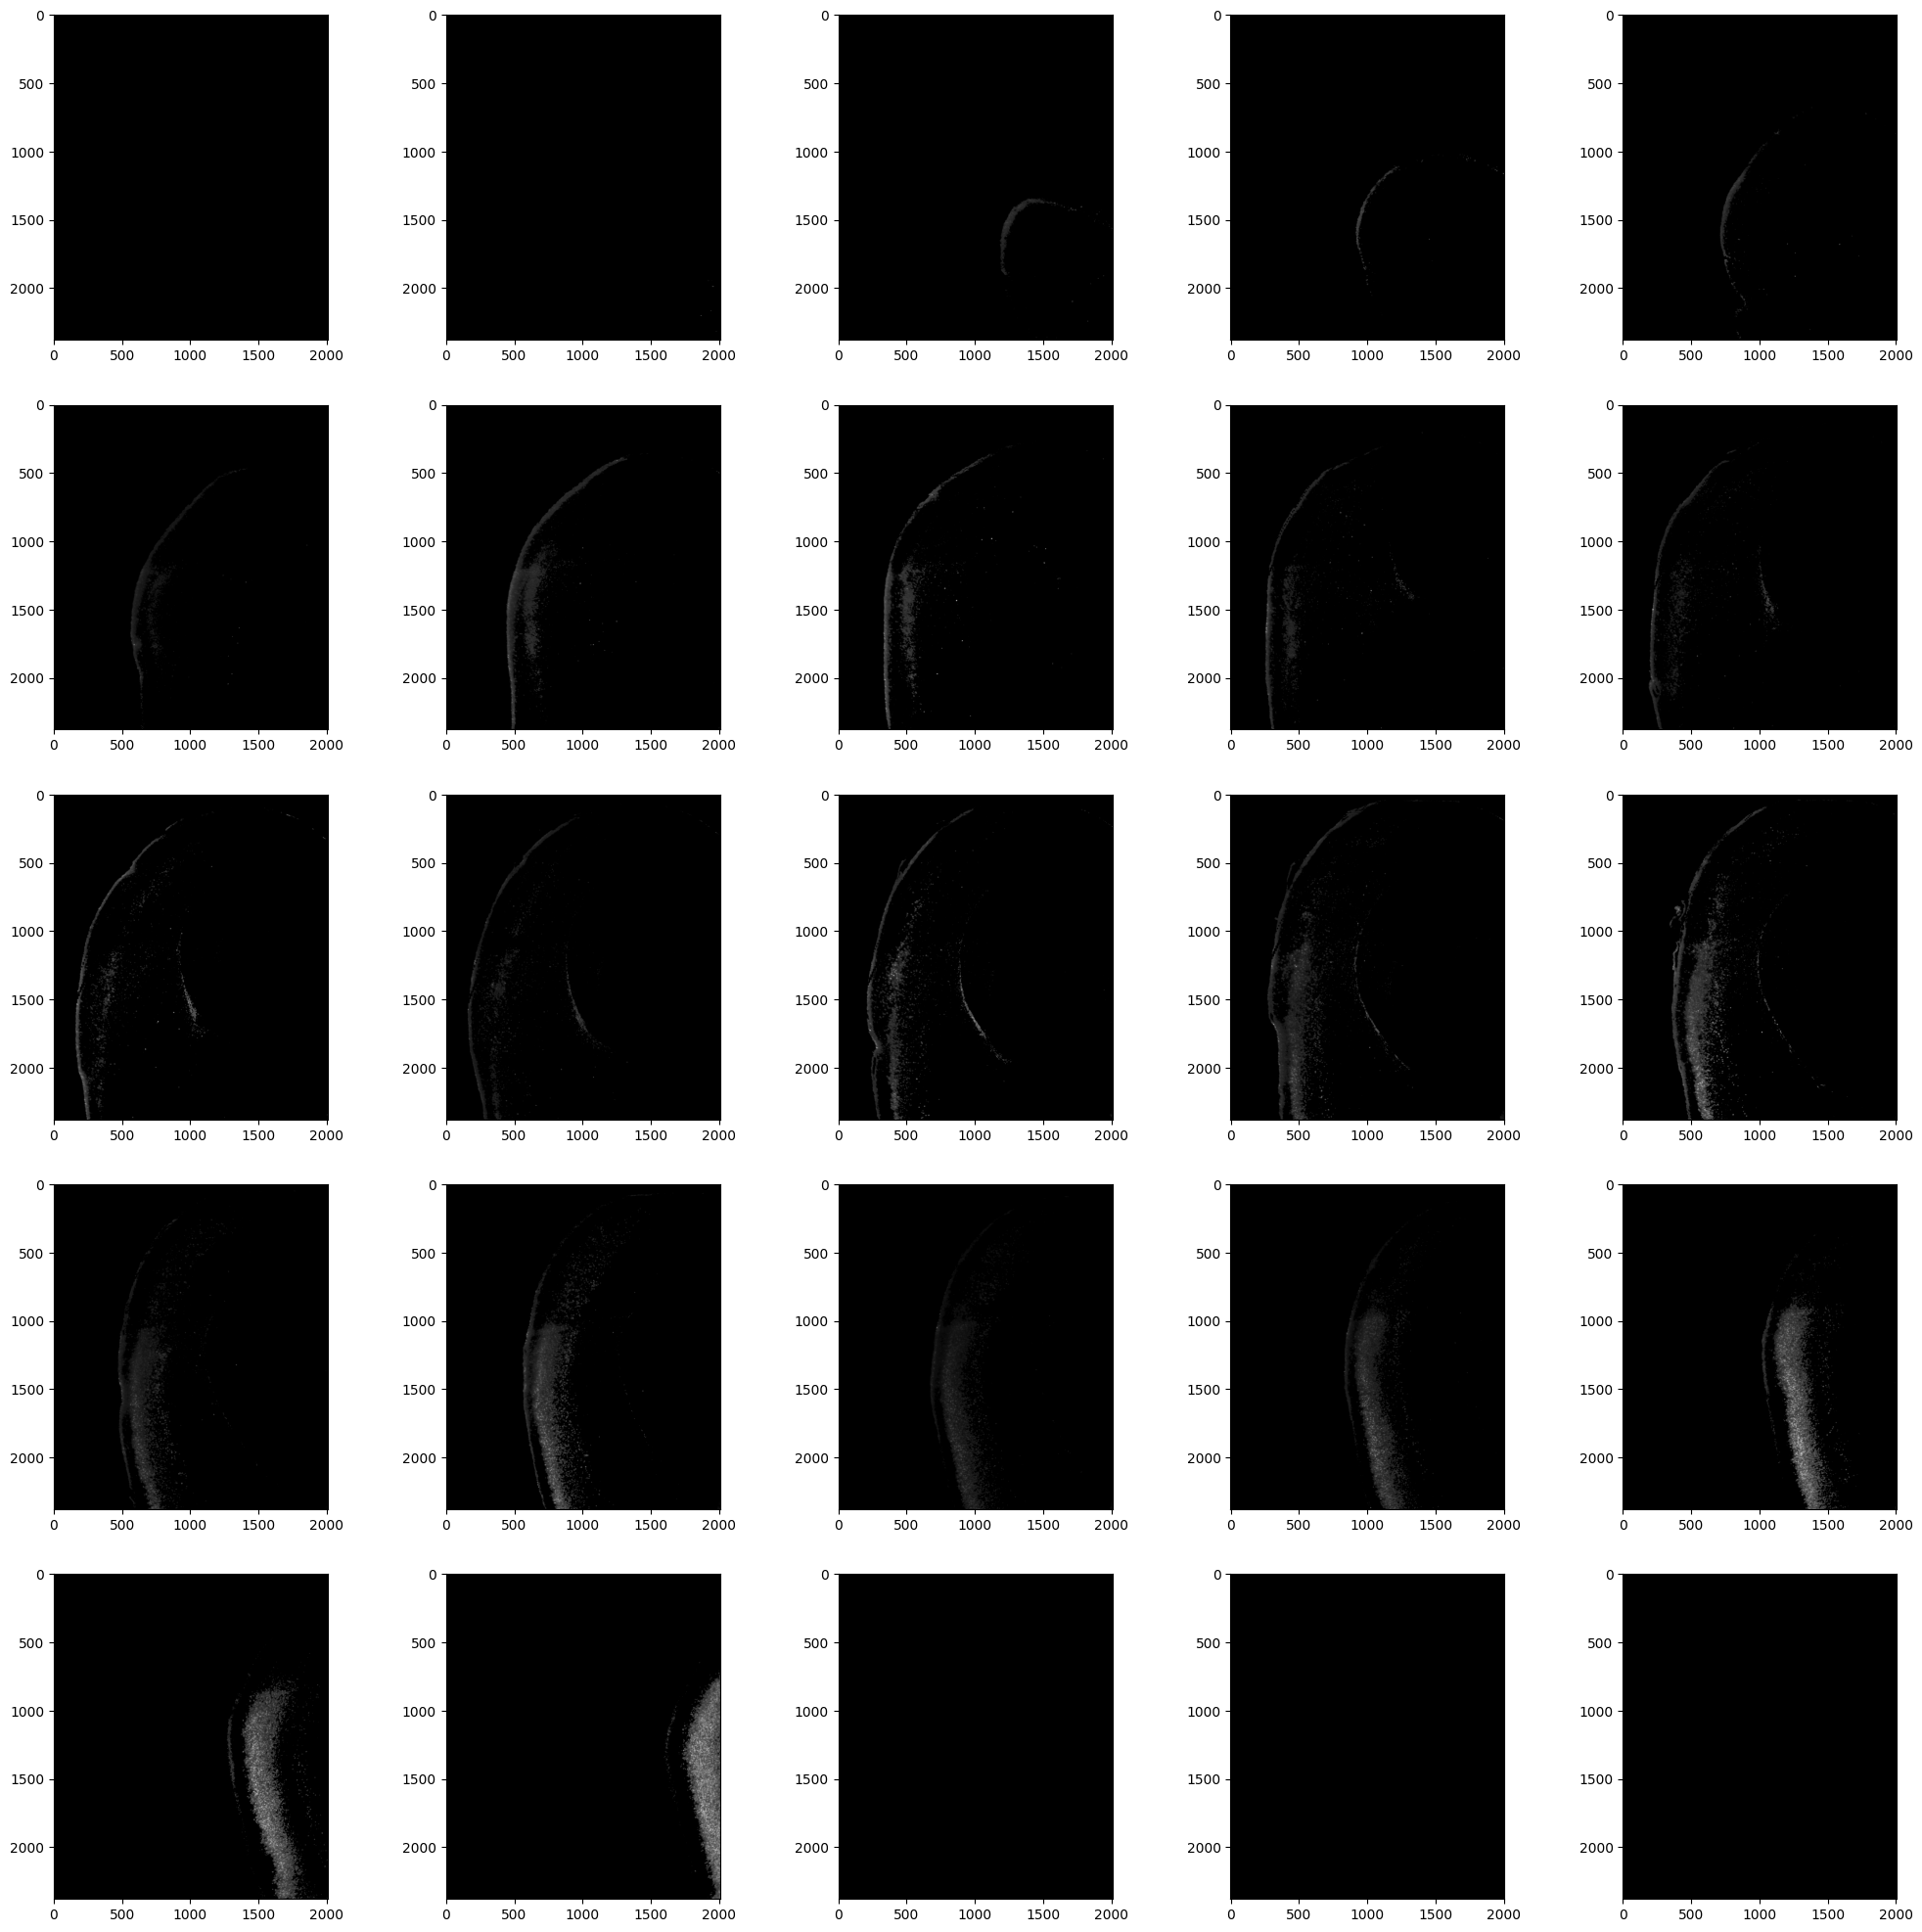

In [13]:
'''
Coloring fg mask
'''
vis_row_n = 5
fig, ax = plt.subplots(vis_row_n, vis_row_n, figsize=(5*vis_row_n, 5*vis_row_n))
ax = ax.reshape(-1)
zinterval = int(len(img3d_c1)/(vis_row_n**2-1))
zranges = [[z, z+zinterval] for z in range(0, len(img3d_c1), zinterval)]
zranges = zranges[:len(ax)]
pix_max = img3d_c1.max()
pix_min = img3d_c1.min()
for zi, (zmin, zmax) in enumerate(zranges):
    z = (zmax+zmin)//2
    z = min(len(img3d_c1)-1, z)
    img_fg = img3d_c1[z].clone()
#     img_all = img3d_c1[z].clone()
#     img_all = (img_all-img3d_c1[z].min()) / (img3d_c1[z].max()-img3d_c1[z].min())
#     img_fg = (img_fg-img3d_c1[z].min()) / (img3d_c1[z].max()-img3d_c1[z].min())
    img_fg[torch.logical_not(fg_mask_c1[z])] = 0
    ax[zi].imshow(img_fg, cmap='gray')


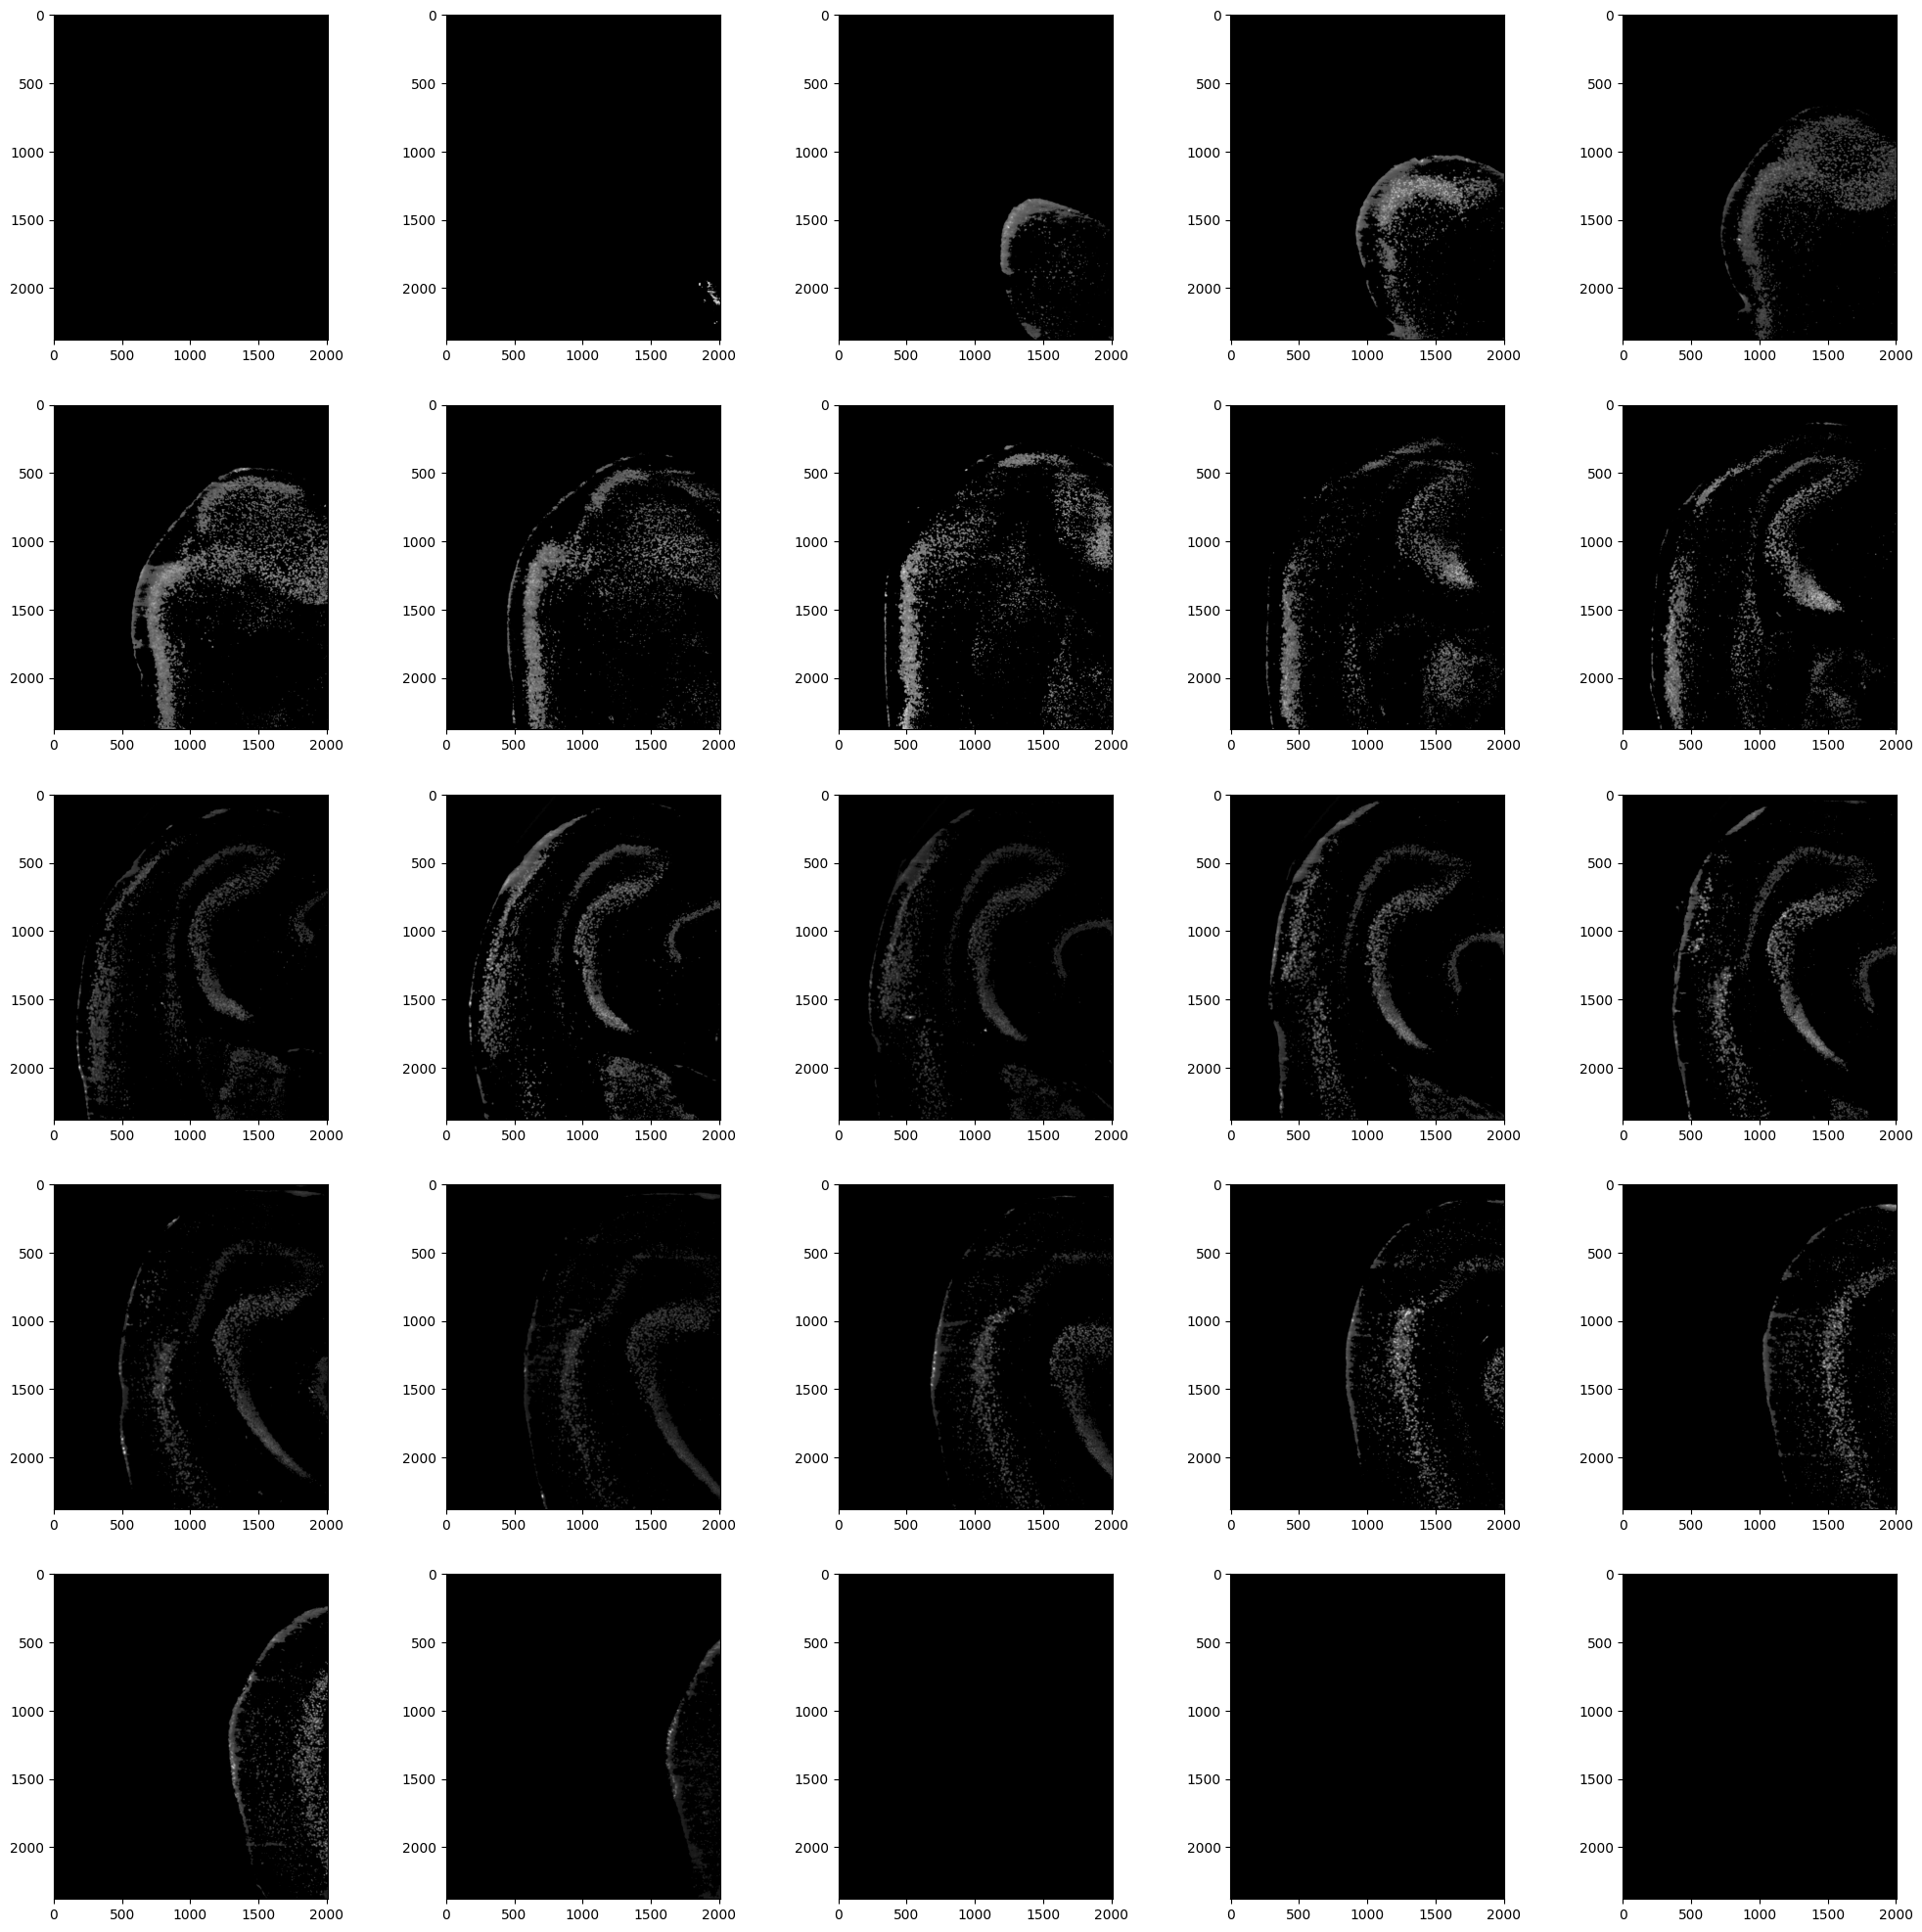

In [14]:
'''
Coloring fg mask
'''
vis_row_n = 5
fig, ax = plt.subplots(vis_row_n, vis_row_n, figsize=(5*vis_row_n, 5*vis_row_n))
ax = ax.reshape(-1)
zinterval = int(len(img3d_c2)/(vis_row_n**2-1))
zranges = [[z, z+zinterval] for z in range(0, len(img3d_c2), zinterval)]
zranges = zranges[:len(ax)]
for zi, (zmin, zmax) in enumerate(zranges):
    z = (zmax+zmin)//2
    z = min(len(img3d_c2)-1, z)
    img_fg = img3d_c2[z].clone()
    img_fg[torch.logical_not(fg_mask_c2[z])] = 0
    ax[zi].imshow(img_fg, cmap='gray')


In [17]:

'''
Load NIS coordinates
'''
coord = []
vol = []
coord_label = []
for stack_name in stack_names:
    zstart = int(stack_name.split('zmin')[1].split('_')[0])
    zstart = int(zstart*zratio)
    coord_fn = f"{result_root % (i, j)}/{stack_name.replace('instance_center', 'instance_coordinate')}"
    vol_fn = f"{result_root % (i, j)}/{stack_name.replace('instance_center', 'instance_volume')}"
    c = torch.load(coord_fn).float()
    c[:, 0] = c[:, 0]*zratio + zstart
    vol.append(torch.load(vol_fn))
    coord.append(c)
    labelfn = f"{result_root % (i, j)}/{stack_name.replace('instance_center', 'instance_label')}"
    coord_label.append(torch.repeat_interleave(torch.load(labelfn).long(), vol[-1]))

coord = torch.cat(coord)#.to(device)
coord_label = torch.cat(coord_label)#.to(device)
vol = torch.cat(vol)#.to(device)
print(coord_label.shape, coord.shape, vol.shape)


torch.Size([1265074985]) torch.Size([1265074985, 3]) torch.Size([2979691])


In [19]:
cumsum_vol = vol.cumsum(0)
nis_ind = [0] + cumsum_vol.tolist()
print(cumsum_vol.shape, cumsum_vol[-1], len(nis_ind))

torch.Size([2979691]) tensor(1265074985) 2979692


In [23]:
torch.randn(10).unique(sorted=False)

tensor([ 0.0599,  0.2572, -1.8720, -1.7878,  1.9004,  0.2079, -0.7130,  1.2736,
         0.7845, -0.1272])

In [34]:
from torch_scatter import scatter_max

batch_size = 10000
device = 'cuda:1'
fg_mask_c1 = fg_mask_c1.to(device)
fg_mask_c2 = fg_mask_c2.to(device)
for i in range(0, len(nis_ind), batch_size):
    ind = nis_ind[i:i+batch_size]
    min_ind, max_ind = ind[0], ind[-1]
    c = coord[min_ind:max_ind].to(device).long()
    print(c.dtype, c.max(0)[0], c.min(0)[0])
    c_label = coord_label[min_ind:max_ind].to(device)
    min_label = c_label.min()
    c_label = c_label - min_label
    nis_c1 = scatter_max(fg_mask_c1[c[:, 0], c[:, 1], c[:, 2]].float(), c_label)[0] > 0
    nis_c2 = scatter_max(fg_mask_c2[c[:, 0], c[:, 1], c[:, 2]].float(), c_label)[0] > 0
    print(nis_c1.shape, nis_c2.shape, c_label.unique().shape, c_label.min(), c_label.max())
    nis_c1 = nis_c1[c_label.unique(sorted=False)]
    nis_c2 = nis_c2[c_label.unique(sorted=False)]
    print(nis_c1.shape, nis_c2.shape, c_label.unique().shape, nis_c1.unique(), nis_c2.unique())
    
    break


torch.int64 tensor([ 598, 2378, 2006], device='cuda:1') tensor([ 65,  30, 157], device='cuda:1')
torch.Size([20359]) torch.Size([20359]) torch.Size([9999]) tensor(0, device='cuda:1') tensor(20358, device='cuda:1')
torch.Size([9999]) torch.Size([9999]) torch.Size([9999]) tensor([False,  True], device='cuda:1') tensor([False,  True], device='cuda:1')


[torch.Size([20359]), torch.Size([20359])]


In [ ]:
'''
NIS mask on fg mask
'''
lrange = 10000

i = 0
coord_batch = torch.nn.utils.rnn.pad_sequence(coord[i:i+lrange], batch_first=True)#.to(device)
coord_batch.shape

# for i in range(0, len(coord), lrange):
#     coord_batch = torch.nn.utils.rnn.pad_sequence(coord[i:i+lrange], batch_first=True).to(device)
#     coord_batch

In [14]:

'''
Load bounding box
'''
bbox = []
label = []
for stack_name in stack_names:
    zstart = int(stack_name.split('zmin')[1].split('_')[0])
    zstart = int(zstart*zratio)
    bboxfn = f"{result_root % (i, j)}/{stack_name.replace('instance_center', 'instance_bbox')}"
    b = torch.load(bboxfn).float()
    b[:, 0] = b[:, 0]*zratio + zstart
    b[:, 3] = b[:, 3]*zratio + zstart
    bbox.append(b)
    labelfn = f"{result_root % (i, j)}/{stack_name.replace('instance_center', 'instance_label')}"
    label.append(torch.load(labelfn).long())

bbox = torch.cat(bbox).to(device)
label = torch.cat(label).to(device)
###########################
zstitch_remap = torch.load(f"{result_root % (i, j)}/{btag.split('_')[1]}_remap.zip").to(device)
print("z-stitch remap dict shape", zstitch_remap.shape)

## loc: gnn stitch source (current tile) nis index, stitch_remap_loc: index of pairs in the stitch remap list
loc, stitch_remap_loc = [], []
for lrangei in range(0, len(label), lrange):
    lo, stitch_remap_lo = torch.where(label[lrangei:lrangei+lrange, None] == zstitch_remap[0, None, :])
    loc.append(lo+lrangei)
    stitch_remap_loc.append(stitch_remap_lo)
loc, stitch_remap_loc = torch.cat(loc), torch.cat(stitch_remap_loc)

## pre_loc: gnn stitch target (previous tile) nis index, tloc: index of remaining Z stitch pairs after nis being removed by X-Y stitching
pre_loc, tloc = [], []
for lrangei in range(0, len(label), lrange):
    pre_lo, tlo = torch.where(label[lrangei:lrangei+lrange, None] == zstitch_remap[1, None, stitch_remap_loc])
    pre_loc.append(pre_lo+lrangei)
    tloc.append(tlo)
pre_loc, tloc = torch.cat(pre_loc), torch.cat(tloc)

## source nis is removed from keeping mask
keep_mask = torch.ones(len(bbox)).bool()
keep_mask[loc] = False

# merge stitched source nis to target nis
loc = loc[tloc]
bbox[pre_loc, :3] = torch.stack([bbox[loc, :3], bbox[pre_loc, :3]]).min(0)[0]
bbox[pre_loc, 3:] = torch.stack([bbox[loc, 3:], bbox[pre_loc, 3:]]).max(0)[0]

bbox = bbox[keep_mask]
label = label[keep_mask]
###########################


z-stitch remap dict shape torch.Size([2, 14683])


torch.Size([476515426, 3])

In [23]:
coord.shape

torch.Size([1265074985, 3])

In [24]:
vol.shape

torch.Size([2979691])

torch.Size([2, 788559559, 3])

In [19]:
device = 'cuda:3'
bbox[:, 0] = bbox[:, 0].clip(min=0, max=seg_shape[0]-1)
bbox[:, 1] = bbox[:, 1].clip(min=0, max=seg_shape[1]-1)
bbox[:, 2] = bbox[:, 2].clip(min=0, max=seg_shape[2]-1)
bbox[:, 3] = bbox[:, 3].clip(min=0, max=seg_shape[0])
bbox[:, 4] = bbox[:, 4].clip(min=0, max=seg_shape[1])
bbox[:, 5] = bbox[:, 5].clip(min=0, max=seg_shape[2])
area = []
nis_fg_c1_perc = []
nis_fg_c2_perc = []
zero_area_ind = []
bi = 0
for b in tqdm(bbox, desc=f'{datetime.now()} Get intensity difference of tile {i},{j} inside NIS'):
    b = b.long()
    nis = fg_mask_c1[b[0]:b[3], b[1]:b[4], b[2]:b[5]].to(device)
    nis_area = nis.shape[0]*nis.shape[1]*nis.shape[2]
    if nis_area == 0: 
        zero_area_ind.append(bi)
        bi += 1
        continue
        
    fg_len = nis.sum().cpu().item()
    
    nis_fg_c1_perc.append(fg_len/nis_area)
    
    nis = fg_mask_c2[b[0]:b[3], b[1]:b[4], b[2]:b[5]].to(device)
    
    fg_len = nis.sum().cpu().item()
    
    nis_fg_c2_perc.append(fg_len/nis_area)
    area.append(nis_area)
    bi += 1

sns_data = {
    'avg intensity': nis_fg_c1_perc+nis_fg_c2_perc,
    'channel': ['C00' for _ in range(len(nis_fg_c1_perc))] + ['C02' for _ in range(len(nis_fg_c2_perc))],
}
sns.displot(data=sns_data, x="avg intensity", hue='channel', kde=True)
# plt.savefig(f'{save_path % (i, j)}/{btag.split("_")[1]}_coloc_avg_intensity_dist.png')
# plt.savefig(f'{save_path % (i, j)}/{btag.split("_")[1]}_coloc_avg_intensity_dist.svg')

# nis_is_c1 = []
# for diff in tqdm(nis_intensity_diff, desc=f'{datetime.now()} Coloc by intensity difference of tile {i},{j} inside NIS'):
#     nis_is_c1.append(diff.mean() > 0)

# torch.save(nis_is_c1, f'{save_path % (i, j)}/{btag.split("_")[1]}_coloc_is_c1.zip')


2024-07-26 15:48:31.087679 Get intensity difference of tile 0,0 inside NIS:   2%| | 49734/2965272 [00:23<18:54Exception ignored in: <generator object tqdm.__iter__ at 0x7fbb0bd1c0d0>
Traceback (most recent call last):
  File "/ram/USERS/ziquanw/softwares/miniconda3/envs/wholeBrain/lib/python3.7/site-packages/tqdm/std.py", line 1179, in __iter__
    yield obj
KeyboardInterrupt: 
2024-07-26 15:48:31.087679 Get intensity difference of tile 0,0 inside NIS:   2%| | 49734/2965272 [00:25<25:03


KeyboardInterrupt: 

In [ ]:
fg_c1
for b in tqdm(bbox, desc=f'{datetime.now()} Get intensity difference of tile {i},{j} inside NIS'):
    b = b.long()
    nis = fg_mask_c1[b[0]:b[3], b[1]:b[4], b[2]:b[5]].to(device)
    nis_area = nis.shape[0]*nis.shape[1]*nis.shape[2]
    if nis_area == 0: 
        zero_area_ind.append(bi)
        bi += 1
        continue
        
    fg_len = nis.sum().cpu().item()
    
    nis_fg_c1_perc.append(fg_len/nis_area)
    
    nis = fg_mask_c2[b[0]:b[3], b[1]:b[4], b[2]:b[5]].to(device)
    
    fg_len = nis.sum().cpu().item()
    
    nis_fg_c2_perc.append(fg_len/nis_area)
    area.append(nis_area)
    bi += 1


[[2341, 2632], [2632, 2923], [2923, 3214], [3214, 3505], [3505, 3796], [3796, 4087], [4087, 4378], [4378, 4669], [4669, 4960], [4960, 5251], [5251, 5542]]
2341 2632
torch.Size([31037]) torch.Size([31037]) torch.Size([82689]) torch.Size([82689])
2632 2923
torch.Size([94016]) torch.Size([94016]) torch.Size([221740]) torch.Size([221740])
2923 3214
torch.Size([136297]) torch.Size([136297]) torch.Size([351362]) torch.Size([351362])
3214 3505
torch.Size([163545]) torch.Size([163545]) torch.Size([484387]) torch.Size([484387])
3505 3796
torch.Size([183358]) torch.Size([183358]) torch.Size([618715]) torch.Size([618715])
3796 4087
torch.Size([149415]) torch.Size([149415]) torch.Size([726577]) torch.Size([726577])
4087 4378
torch.Size([79820]) torch.Size([79820]) torch.Size([748801]) torch.Size([748801])
4378 4669
torch.Size([12330]) torch.Size([12330]) torch.Size([541146]) torch.Size([541146])
4669 4960
4960 5251
5251 5542


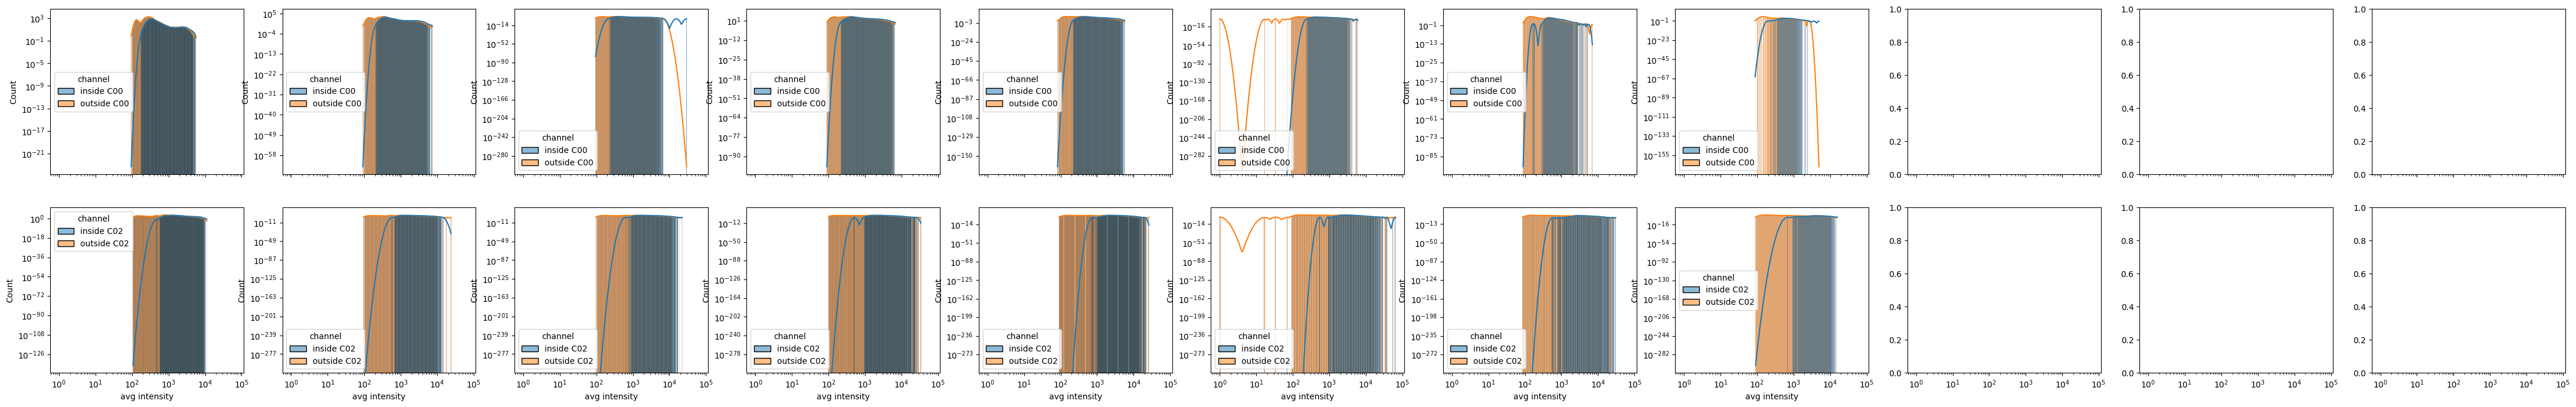

In [27]:
dinterval = int((grid_dis_to_center.max() - grid_dis_to_center.min())/10)
dranges = [[d, d+dinterval] for d in range(grid_dis_to_center.min().long(), grid_dis_to_center.max().long()+1, dinterval)]
print(dranges)
fig, ax = plt.subplots(2, len(dranges), figsize=(5*len(dranges),8), sharex=True)
for di, (dmin, dmax) in enumerate(dranges):
    print(dmin, dmax)
    dmask = torch.logical_and(org_grid_dis_to_center >= dmin, org_grid_dis_to_center < dmax)
    if not torch.logical_and(binary_mask, dmask).any(): continue
    intensity_inside_c1 = torch.nn.functional.interpolate(img3d_c1[torch.logical_and(binary_mask, dmask)][None,None], scale_factor=down_ratio**D)[0, 0]
    intensity_inside_c2 = torch.nn.functional.interpolate(img3d_c2[torch.logical_and(binary_mask, dmask)][None,None], scale_factor=down_ratio**D)[0, 0]
    intensity_outside_c1 = torch.nn.functional.interpolate(img3d_c1[torch.logical_and(torch.logical_not(binary_mask), dmask)][None,None], scale_factor=down_ratio**D)[0, 0]
    intensity_outside_c2 = torch.nn.functional.interpolate(img3d_c2[torch.logical_and(torch.logical_not(binary_mask), dmask)][None,None], scale_factor=down_ratio**D)[0, 0]
    print(intensity_inside_c1.shape,
    intensity_inside_c2.shape,
    intensity_outside_c1.shape,
    intensity_outside_c2.shape,)
    intensity_inside_c1 = intensity_inside_c1.clip(min=1)
    intensity_inside_c2 = intensity_inside_c2.clip(min=1)
    intensity_outside_c1 = intensity_outside_c1.clip(min=1)
    intensity_outside_c2 = intensity_outside_c2.clip(min=1)
    sns_data = {
        'avg intensity': intensity_inside_c1.tolist()+intensity_outside_c1.tolist(),
        'channel': ['inside C00' for _ in range(len(intensity_inside_c1))] + ['outside C00' for _ in range(len(intensity_outside_c1))],
    }
    sns.histplot(data=sns_data, x="avg intensity", hue='channel', kde=True, ax=ax[0, di], log_scale=(True, True))

    sns_data = {
        'avg intensity': intensity_inside_c2.tolist()+intensity_outside_c2.tolist(),
        'channel': ['inside C02' for _ in range(len(intensity_inside_c1))] + ['outside C02' for _ in range(len(intensity_outside_c1))],
    }
    sns.histplot(data=sns_data, x="avg intensity", hue='channel', kde=True, ax=ax[1, di], log_scale=(True, True))


In [15]:
849822+4168337

5018159

<AxesSubplot:xlabel='avg intensity', ylabel='Count'>

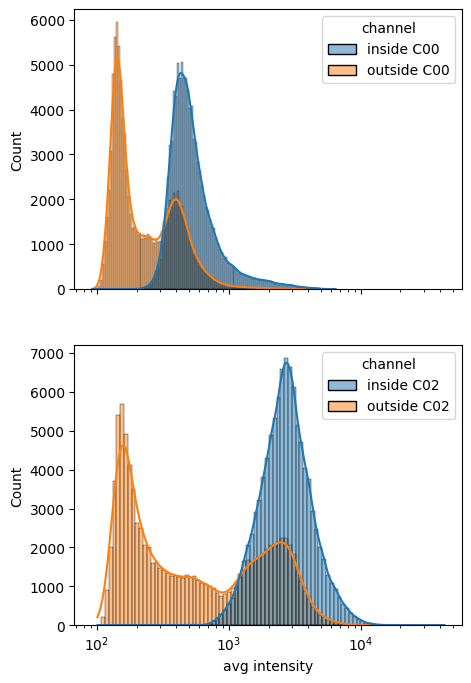

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(5,8), sharex=True)
sns_data = {
    'avg intensity': intensity_inside_c1.tolist()+intensity_outside_c1.tolist(),
    'channel': ['inside C00' for _ in range(len(intensity_inside_c1))] + ['outside C00' for _ in range(len(intensity_outside_c1))],
}
sns.histplot(data=sns_data, x="avg intensity", hue='channel', kde=True, ax=ax[0], log_scale=(True, False))

sns_data = {
    'avg intensity': intensity_inside_c2.tolist()+intensity_outside_c2.tolist(),
    'channel': ['inside C02' for _ in range(len(intensity_inside_c1))] + ['outside C02' for _ in range(len(intensity_outside_c1))],
}
sns.histplot(data=sns_data, x="avg intensity", hue='channel', kde=True, ax=ax[1], log_scale=(True, False))


[[1161, 1453], [1453, 1745], [1745, 2037], [2037, 2329], [2329, 2621], [2621, 2913]]
1161 1453
1453 1745
1745 2037


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/ram/USERS/ziquanw/softwares/miniconda3/envs/wholeBrain/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2590367/748387514.py", line 17, in <module>
    sns.histplot(data=sns_data, x="avg intensity", hue='channel', kde=True, ax=ax[0, di], log_scale=(True, False))
  File "/ram/USERS/ziquanw/softwares/miniconda3/envs/wholeBrain/lib/python3.7/site-packages/seaborn/distributions.py", line 1397, in histplot
    variables=_DistributionPlotter.get_semantics(locals())
  File "/ram/USERS/ziquanw/softwares/miniconda3/envs/wholeBrain/lib/python3.7/site-packages/seaborn/distributions.py", line 113, in __init__
    super().__init__(data=data, variables=variables)
  File "/ram/USERS/ziquanw/softwares/miniconda3/envs/wholeBrain/lib/python3.7/site-packages/seaborn/_oldcore.py", line 640, in __init__
    self.assign_variables(data, variables)
  Fil

TypeError: object of type 'NoneType' has no len()

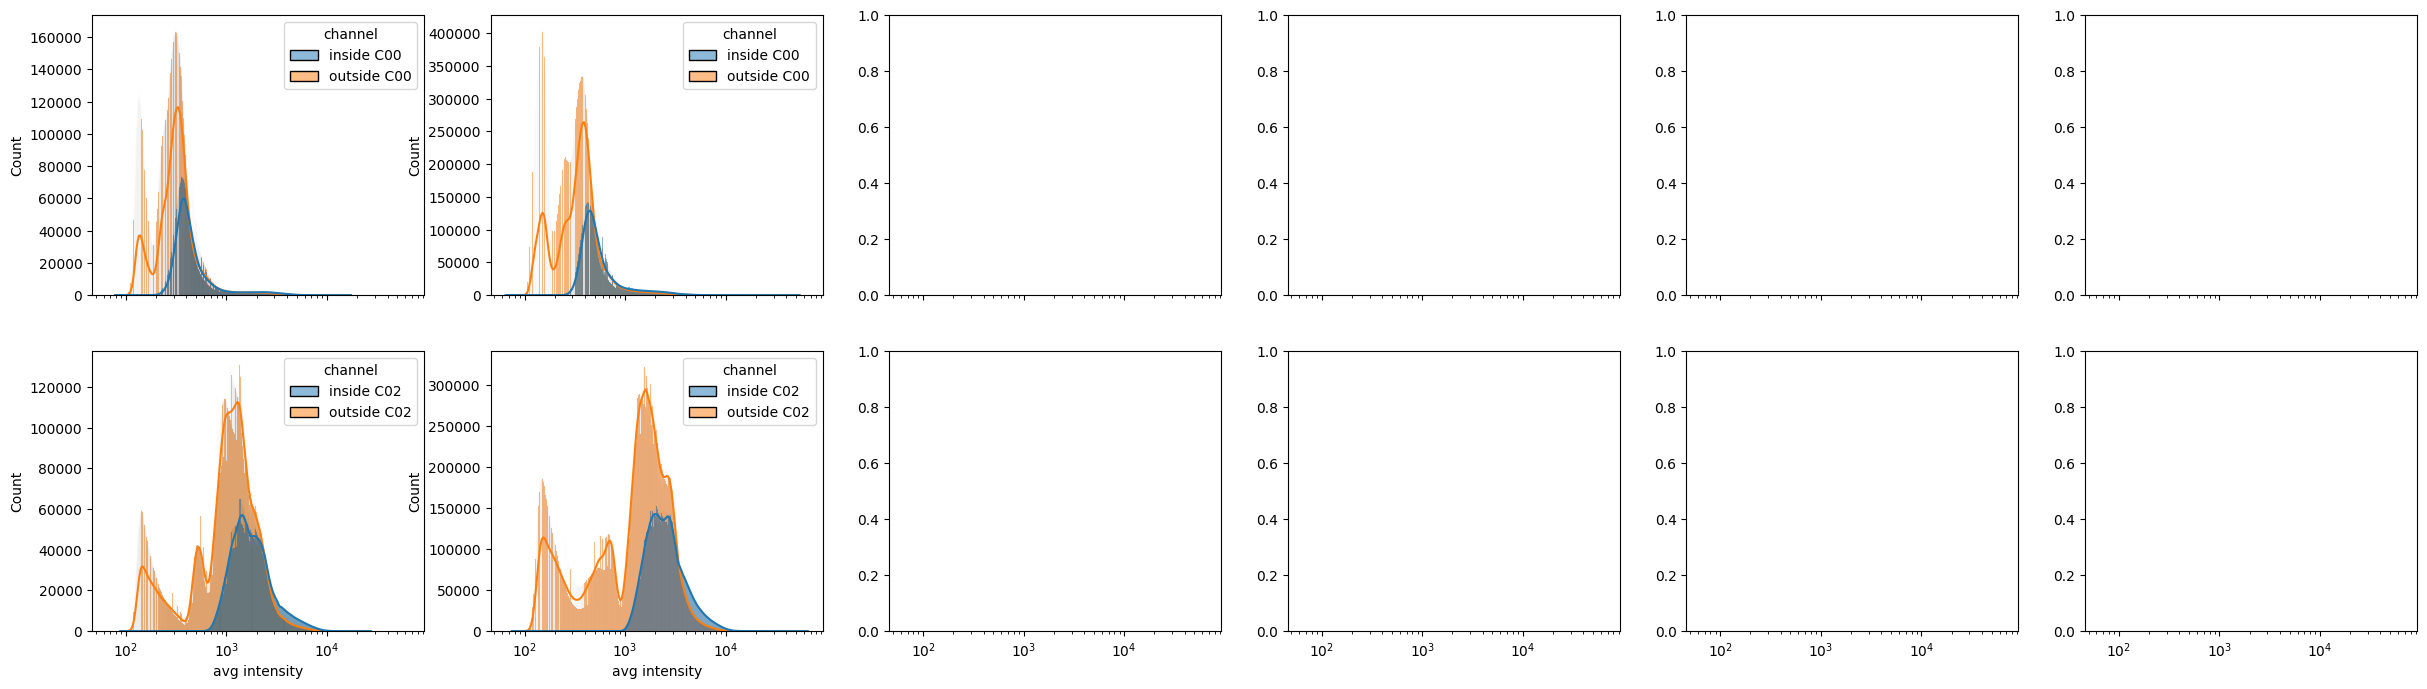

In [61]:
dinterval = int((grid_dis_to_center.max() - grid_dis_to_center.min())/5)
dranges = [[d, d+dinterval] for d in range(grid_dis_to_center.min().long(), grid_dis_to_center.max().long()+1, dinterval)]
print(dranges)
fig, ax = plt.subplots(2, len(dranges), figsize=(5*len(dranges),8), sharex=True)
for di, (dmin, dmax) in enumerate(dranges):
    print(dmin, dmax)
    dmask = torch.logical_and(grid_dis_to_center >= dmin, grid_dis_to_center < dmax)
    intensity_inside_c1 = img3d_c1[torch.logical_and(binary_mask, dmask)]
    intensity_inside_c2 = img3d_c2[torch.logical_and(binary_mask, dmask)]
    intensity_outside_c1 = img3d_c1[torch.logical_and(torch.logical_not(binary_mask), dmask)]
    intensity_outside_c2 = img3d_c2[torch.logical_and(torch.logical_not(binary_mask), dmask)]
    
    sns_data = {
        'avg intensity': intensity_inside_c1.tolist()+intensity_outside_c1.tolist(),
        'channel': ['inside C00' for _ in range(len(intensity_inside_c1))] + ['outside C00' for _ in range(len(intensity_outside_c1))],
    }
    sns.histplot(data=sns_data, x="avg intensity", hue='channel', kde=True, ax=ax[0, di], log_scale=(True, False))

    sns_data = {
        'avg intensity': intensity_inside_c2.tolist()+intensity_outside_c2.tolist(),
        'channel': ['inside C02' for _ in range(len(intensity_inside_c1))] + ['outside C02' for _ in range(len(intensity_outside_c1))],
    }
    sns.histplot(data=sns_data, x="avg intensity", hue='channel', kde=True, ax=ax[1, di], log_scale=(True, False))
